In [2]:
import pandas as pd
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import os
import cv2
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import expand_dims, argmax
import keras
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import resnet50, inception_v3, vgg16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow import keras
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

scaler = MinMaxScaler()

%matplotlib inline

### **Reading data in proper format**

In [3]:
df = pd.read_csv('../input/csv-mod-dataset/Module_1 - Rooftop_Detectection_Mod_Dataset.csv')

### **Storing image names in list**

In [7]:
path = '../input/rooftype-dataset-mod-2/rooftype-dataset-mod'
image_names = []
labels = []

for img in glob.glob(os.path.join(path, 'Flat-jpg', '*')):
    image_names.append(img)
    labels.append(0)
    
for img in glob.glob(os.path.join(path, 'Gable-jpg', '*')):
    image_names.append(img)
    labels.append(1)
    
for img in glob.glob(os.path.join(path, 'Hip-jpg', '*')):
    image_names.append(img)
    labels.append(2)

print("No of images: {0}".format(len(image_names)))
print("Labels: {0}".format(len(labels)))

No of images: 1115
Labels: 1115


### **Shuffle list**

In [8]:
zipped_list = list(zip(image_names, labels))
random.shuffle(zipped_list)
image_names, labels = zip(*zipped_list)
image_names, labels = list(image_names), list(labels)

print(image_names)
print(labels)

['../input/rooftype-dataset-mod-2/rooftype-dataset-mod/Hip-jpg/christchurch_173_401.jpg', '../input/rooftype-dataset-mod-2/rooftype-dataset-mod/Hip-jpg/christchurch_215_104.jpg', '../input/rooftype-dataset-mod-2/rooftype-dataset-mod/Gable-jpg/christchurch_174_41.jpg', '../input/rooftype-dataset-mod-2/rooftype-dataset-mod/Flat-jpg/VvgAd-24205.jpg', '../input/rooftype-dataset-mod-2/rooftype-dataset-mod/Hip-jpg/DgNZC-75103.jpg', '../input/rooftype-dataset-mod-2/rooftype-dataset-mod/Flat-jpg/christchurch_215_550.jpg', '../input/rooftype-dataset-mod-2/rooftype-dataset-mod/Gable-jpg/christchurch_173_297.jpg', '../input/rooftype-dataset-mod-2/rooftype-dataset-mod/Hip-jpg/christchurch_215_590.jpg', '../input/rooftype-dataset-mod-2/rooftype-dataset-mod/Gable-jpg/christchurch_215_83.jpg', '../input/rooftype-dataset-mod-2/rooftype-dataset-mod/Gable-jpg/christchurch_215_547.jpg', '../input/rooftype-dataset-mod-2/rooftype-dataset-mod/Gable-jpg/christchurch_215_456.jpg', '../input/rooftype-dataset-m

### **Pre-processing**

In [9]:
X = []
Y = []
for img in image_names:
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_CUBIC)
    X.append(resized_img)

Y = labels

In [10]:
X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)

(1115, 256, 256, 3) (1115,)


In [11]:
X = X.astype('float32')
X /= 255.
Y = Y.reshape(Y.shape[0],1)
print(X.shape, Y.shape)

(1115, 256, 256, 3) (1115, 1)


### **Train-test split**

In [12]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.04)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size = 0.05)

In [13]:
print("Train X: {0}, Train Y: {1}".format(train_X.shape, train_Y.shape))
print("Val X: {0}, Val Y: {1}".format(val_X.shape, val_Y.shape))
print("Test X: {0}, Test Y: {1}".format(test_X.shape, test_Y.shape))

Train X: (1016, 256, 256, 3), Train Y: (1016, 1)
Val X: (54, 256, 256, 3), Val Y: (54, 1)
Test X: (45, 256, 256, 3), Test Y: (45, 1)


### **One-hot encoding**

In [14]:
train_Y = to_categorical(train_Y, num_classes = 3)
val_Y = to_categorical(val_Y, num_classes = 3)
test_Y = to_categorical(test_Y, num_classes = 3)

print("Shape: {0}, {1}, {2}".format(train_Y.shape, val_Y.shape, test_Y.shape))

Shape: (1016, 3), (54, 3), (45, 3)


### **Plotting images**

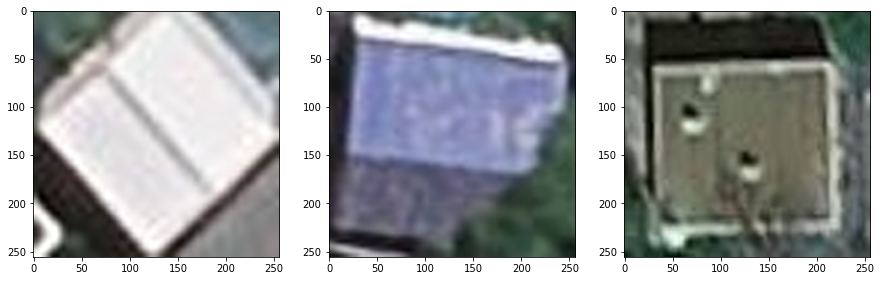

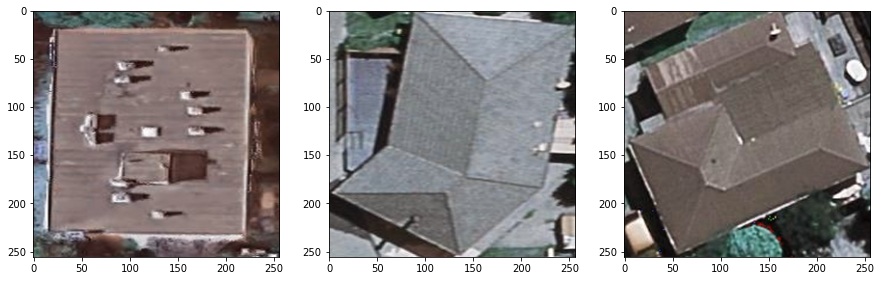

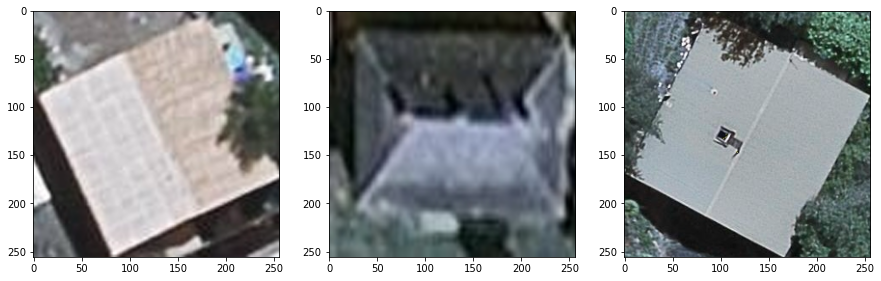

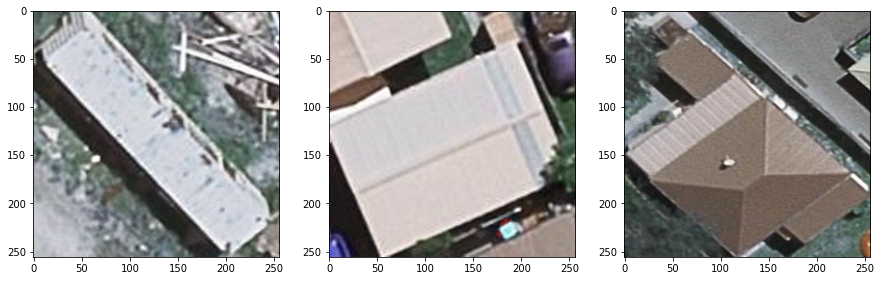

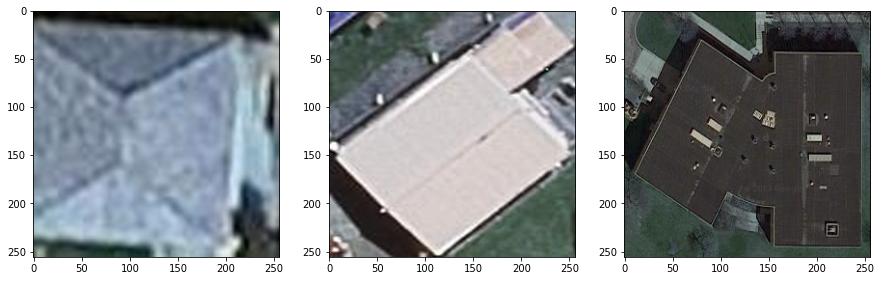

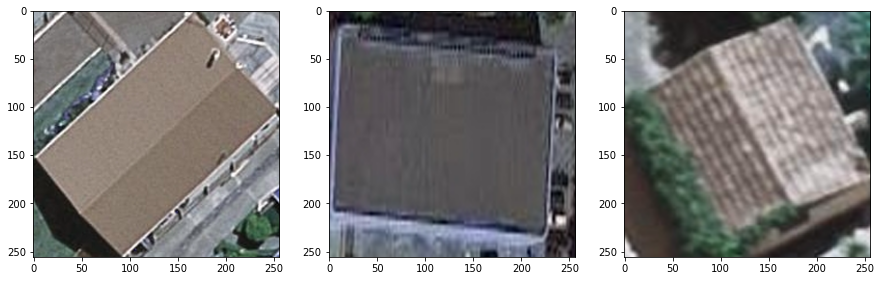

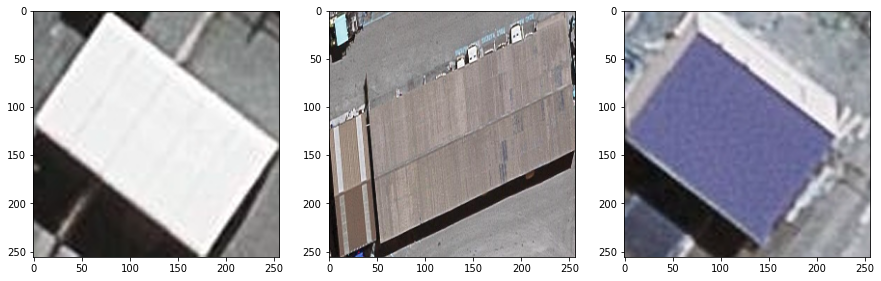

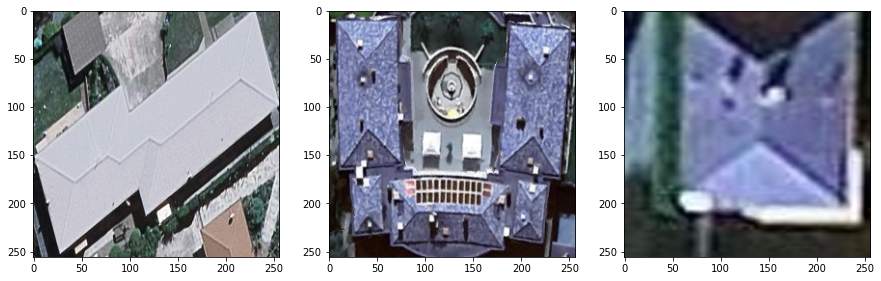

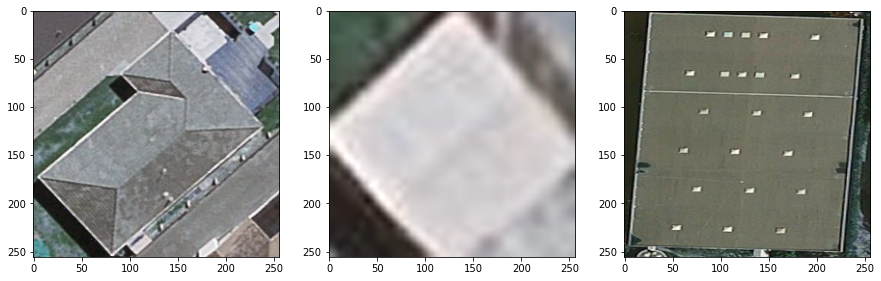

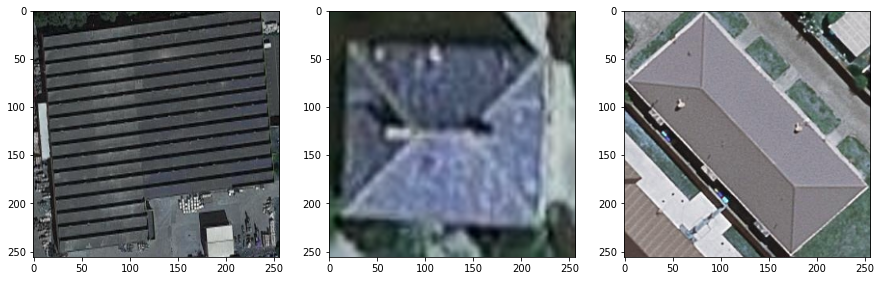

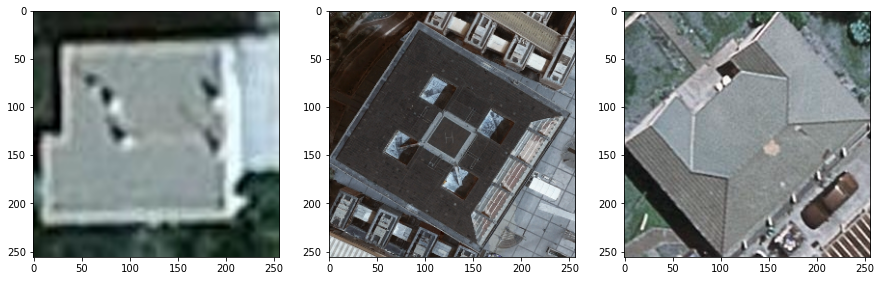

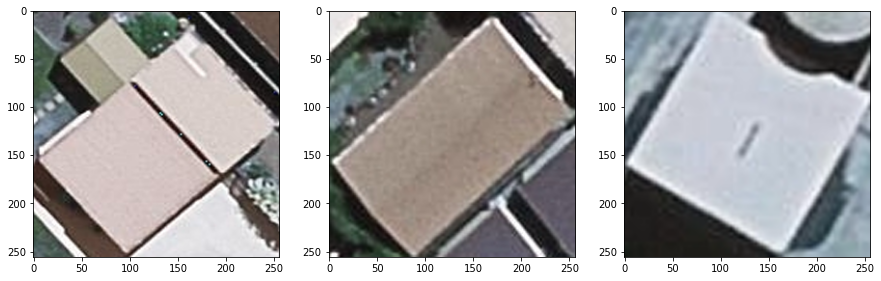

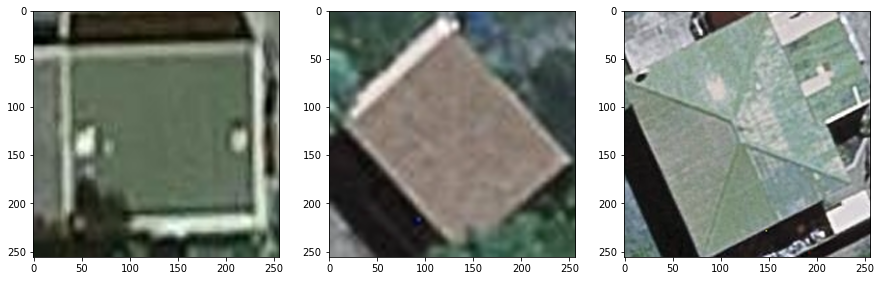

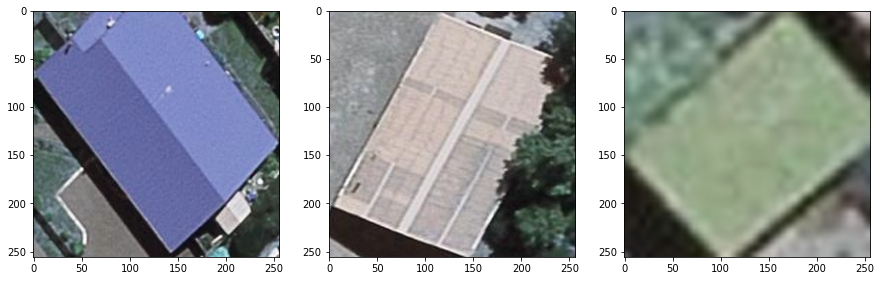

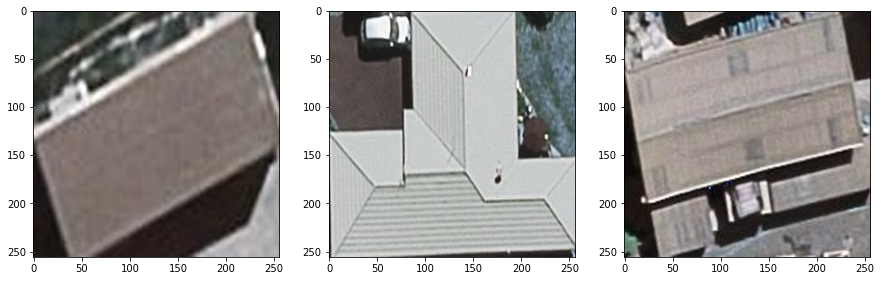

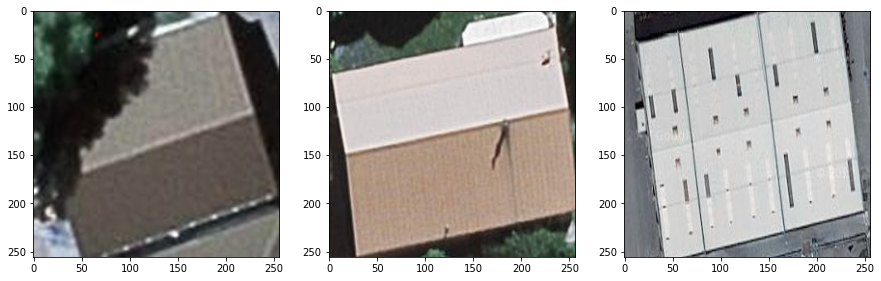

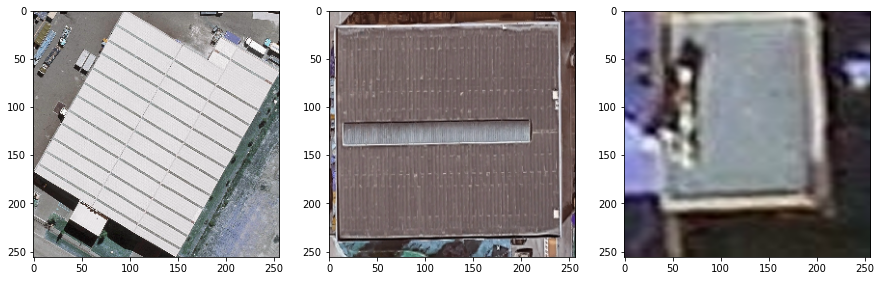

In [15]:
rows = 36
columns = 3
count = 1
for image_number in range(0,50, 3):

    fig = plt.figure(figsize=(15,15))

    fig.add_subplot(rows, columns, count)
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(train_X[image_number:image_number+1]))

    fig.add_subplot(rows, columns, count+1)
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(train_X[image_number+1:image_number+2]))

    fig.add_subplot(rows, columns, count+2)
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(train_X[image_number+2:image_number+3]))

    count += 3


### **Data Augmentation**

In [16]:
data_generation = ImageDataGenerator(
    rotation_range = 7,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.10,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.10,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = True,   # randomly flip images
    fill_mode = 'reflect')  
data_generation.fit(train_X)

### **Plot graphs**

In [17]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'], label = "acc")
    plt.plot(history.history['val_acc'], label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "loss")
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()


### **Make Predictions**

In [18]:
def make_predictions(model, test_X, test_Y):
    test_loss = model.evaluate(test_X, test_Y)
    predictions = model.predict(test_X)
    pred_labels = np.argmax(predictions, axis = 1)
    test_labels = np.argmax(test_Y, axis = 1)
    return pred_labels, test_labels

### **Plot Confusion Matrix**

In [19]:
def plot_confusion_matrix(test_labels, pred_labels):
    Y_test_actual = test_labels
    Y_test_pred = pred_labels
    confusion_mtx = confusion_matrix(Y_test_actual, Y_test_pred) 

    f,ax = plt.subplots(figsize = (8, 8))
    sns.heatmap(confusion_mtx, annot = True, linewidths = 0.01, cmap = "Greens", linecolor = "gray", fmt = '.1f', ax = ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

### **Classification Report**

In [20]:
def print_classification_report(test_labels, pred_labels):
    print("Classification Report: ")
    print(classification_report(test_labels, pred_labels))

### **Plot AUC-ROC Graph**

In [21]:
def plot_AUC_ROC(model, test_X, test_Y):

    predictions = model.predict(test_X) 
    print(predictions)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    print("ROC_AUC score for 3 models: {0}".format(roc_auc))

    # Plot of a ROC curve for a specific class
    for i in range(3):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

### **Validating our model on PotsDam dataset**

In [22]:
potsdam_image_paths_list = []
potsdam_image_labels = []
potsdam_image_path_flat = '../input/potsdam-mini/potsdam-mini/Flat'   # 0
potsdam_image_path_gable = '../input/potsdam-mini/potsdam-mini/Gable' # 1
potsdam_image_path_hip = '../input/potsdam-mini/potsdam-mini/Hip'     # 2



for img_path in glob.glob(os.path.join(potsdam_image_path_flat, '*.tif')):
    potsdam_image_paths_list.append(str(img_path)) 
    potsdam_image_labels.append(0)

for img_path in glob.glob(os.path.join(potsdam_image_path_gable, '*.tif')):
    potsdam_image_paths_list.append(str(img_path))
    potsdam_image_labels.append(1)

for img_path in glob.glob(os.path.join(potsdam_image_path_hip, '*.tif')):
    potsdam_image_paths_list.append(str(img_path)) 
    potsdam_image_labels.append(2)
    
potsdam_image_paths_list.sort()
assert(len(potsdam_image_paths_list) == 300 and len(potsdam_image_labels) == 300)

In [23]:
zipped_list = list(zip(potsdam_image_paths_list, potsdam_image_labels))
random.shuffle(zipped_list)
potsdam_image_paths_list, potsdam_image_labels = zip(*zipped_list)
potsdam_image_paths_list, potsdam_image_labels = list(potsdam_image_paths_list), list(potsdam_image_labels)

print(potsdam_image_paths_list)
print(potsdam_image_labels)

['../input/potsdam-mini/potsdam-mini/Gable/Gable35.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat26.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip54.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip16.tif', '../input/potsdam-mini/potsdam-mini/Gable/Gable97.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat29.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip81.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip63.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat88.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip96.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip60.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip64.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip44.tif', '../input/potsdam-mini/potsdam-mini/Gable/Gable42.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip80.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat32.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat63.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat35.tif', '../input/potsdam-mini/potsdam-mini/Hip

In [24]:
mini_image_paths_list = []
mini_labels = []

for i in range(0,10,1):
    mini_image_paths_list.append(potsdam_image_paths_list[i])
    mini_labels.append(0)
    
for i in range(100,110,1):
    mini_image_paths_list.append(potsdam_image_paths_list[i])
    mini_labels.append(1)
    
for i in range(200,210,1):
    mini_image_paths_list.append(potsdam_image_paths_list[i])
    mini_labels.append(2)
    
print(mini_image_paths_list)
print(mini_labels)

['../input/potsdam-mini/potsdam-mini/Gable/Gable35.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat26.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip54.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip16.tif', '../input/potsdam-mini/potsdam-mini/Gable/Gable97.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat29.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip81.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip63.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat88.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip96.tif', '../input/potsdam-mini/potsdam-mini/Gable/Gable10.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip53.tif', '../input/potsdam-mini/potsdam-mini/Gable/Gable48.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip74.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat5.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip76.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat18.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat46.tif', '../input/potsdam-mini/potsdam-mini/

In [25]:
zipped_list = list(zip(mini_image_paths_list, mini_labels))
random.shuffle(zipped_list)
mini_image_paths_list, mini_labels = zip(*zipped_list)
mini_image_paths_list, mini_labels = list(mini_image_paths_list), list(mini_labels)

print(mini_image_paths_list)
print(mini_labels)

['../input/potsdam-mini/potsdam-mini/Gable/Gable79.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat18.tif', '../input/potsdam-mini/potsdam-mini/Gable/Gable2.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip16.tif', '../input/potsdam-mini/potsdam-mini/Gable/Gable97.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat26.tif', '../input/potsdam-mini/potsdam-mini/Gable/Gable91.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat46.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip76.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat88.tif', '../input/potsdam-mini/potsdam-mini/Gable/Gable35.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip53.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip74.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip81.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat90.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip42.tif', '../input/potsdam-mini/potsdam-mini/Flat/Flat49.tif', '../input/potsdam-mini/potsdam-mini/Hip/Hip87.tif', '../input/potsdam-mini/potsdam-m

In [26]:
# train_X_potsdam = []
# train_Y_potsdam = []
# for i, img in enumerate(mini_image_paths_list):
#     img = cv2.imread(img, cv2.IMREAD_COLOR)
#     resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
#     train_X_potsdam.append(resized_img)
    
# train_Y_potsdam = mini_labels

train_X_potsdam = []
train_Y_potsdam = []
for i, img in enumerate(potsdam_image_paths_list):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_X_potsdam.append(resized_img)
    
train_Y_potsdam = potsdam_image_labels

In [27]:
train_X_potsdam = np.array(train_X_potsdam)
train_Y_potsdam = np.array(train_Y_potsdam)

train_X_potsdam = train_X_potsdam.astype('float32')
train_X_potsdam /= 255.
train_Y_potsdam = train_Y_potsdam.reshape(train_Y_potsdam.shape[0],1)
train_Y_potsdam = to_categorical(train_Y_potsdam, num_classes = 3)

print(train_X_potsdam.shape, train_Y_potsdam.shape)

(300, 256, 256, 3) (300, 3)


### **Test Time Augmentation**

In [28]:
# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
    # convert image into dataset
    samples = expand_dims(image, 0)
    # prepare iterator
    it = datagen.flow(samples, batch_size=n_examples)
    # make predictions for each augmented image
    yhats = model.predict_generator(it, steps=n_examples, verbose=0)
    # sum across predictions
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    return argmax(summed)

In [29]:
# evaluate a model on a dataset using test-time augmentation
def tta_evaluate_model(model, test_X, test_Y):
    # configure image data augmentation
    datagen = ImageDataGenerator( rotation_range = 7,  # randomly rotate images in the range (degrees, 0 to 180)
                                  width_shift_range = 0.10,  # randomly shift images horizontally (fraction of total width)
                                  height_shift_range = 0.10,  # randomly shift images vertically (fraction of total height)
                                  horizontal_flip = True,  # randomly flip images
                                  vertical_flip = True,   # randomly flip images
                                  fill_mode = 'reflect')
    # define the number of augmented images to generate per test set image
    n_examples_per_image = 5
    yhats = list()
    for i in range(len(test_X)):
        # make augmented prediction
        yhat = tta_prediction(datagen, model, test_X[i], n_examples_per_image)
        # store for evaluation
        yhats.append(yhat)
    # calculate accuracy
    print(yhats)
    testY_labels = argmax(test_Y, axis=1)
    acc = accuracy_score(testY_labels, yhats)
    plot_confusion_matrix(testY_labels, yhats)
    print_classification_report(testY_labels, yhats)
    return acc, yhats

### **CNN with RMS Prop**

* Optimizer - RMS Prop
* Learning Rate -0.0001
* Batch size - 16
* Epochs - 50

In [30]:
CNNmodel_RMS = Sequential()

CNNmodel_RMS.add(Conv2D(64, (3, 3), padding='same',
                 input_shape = train_X.shape[1:]))
CNNmodel_RMS.add(Activation('relu'))
CNNmodel_RMS.add(Conv2D(110, (3, 3)))
CNNmodel_RMS.add(Activation('relu'))
CNNmodel_RMS.add(MaxPooling2D(pool_size=(2, 2)))
CNNmodel_RMS.add(Dropout(0.15))

CNNmodel_RMS.add(Conv2D(84, (3, 3), padding='same'))
CNNmodel_RMS.add(Activation('relu'))
CNNmodel_RMS.add(Conv2D(84, (3, 3)))
CNNmodel_RMS.add(Activation('relu'))
CNNmodel_RMS.add(MaxPooling2D(pool_size=(2, 2)))
CNNmodel_RMS.add(Dropout(0.20))

CNNmodel_RMS.add(Conv2D(64, (3, 3), padding='same'))
CNNmodel_RMS.add(Activation('relu'))
CNNmodel_RMS.add(Conv2D(64, (3, 3)))
CNNmodel_RMS.add(Activation('relu'))
CNNmodel_RMS.add(MaxPooling2D(pool_size=(2, 2)))
CNNmodel_RMS.add(Dropout(0.20))

CNNmodel_RMS.add(Conv2D(32, (3, 3), padding='same'))
CNNmodel_RMS.add(Activation('relu'))
CNNmodel_RMS.add(Conv2D(32, (3, 3)))
CNNmodel_RMS.add(Activation('relu'))
CNNmodel_RMS.add(MaxPooling2D(pool_size=(2, 2)))
CNNmodel_RMS.add(Dropout(0.20))

CNNmodel_RMS.add(Flatten())
CNNmodel_RMS.add(Dense(1024))
CNNmodel_RMS.add(Activation('relu'))
CNNmodel_RMS.add(Dense(3))
CNNmodel_RMS.add(Activation('softmax'))

CNNmodel_RMS.summary()


2022-04-30 14:36:24.655535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 14:36:24.755139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 14:36:24.755914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 110)     63470     
_________________________________________________________________
activation_1 (Activation)    (None, 254, 254, 110)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 110)     0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 110)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 127, 84)      8

2022-04-30 14:36:24.757755: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-30 14:36:24.758865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 14:36:24.759583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 14:36:24.760255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [31]:
# checkpoint: save best model during the training 
filepath = "./CNN-RMSProp-50epochs-mod2"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 0, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate = 0.0001, decay = 1e-7)

# Let's train the model using RMSprop
CNNmodel_RMS.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc']) 

In [32]:
history_CNN_RMS = CNNmodel_RMS.fit(data_generation.flow(train_X, train_Y, batch_size = 16),
                                steps_per_epoch = train_X.shape[0] // 16,
                                epochs = 50,
                                validation_data = (val_X, val_Y),
                                callbacks = [callbacks_list])

2022-04-30 14:36:27.670650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-30 14:36:29.663784: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


63/63 [==============================] - 27s 297ms/step - loss: 1.0950 - acc: 0.3990 - val_loss: 1.0935 - val_acc: 0.4444


2022-04-30 14:36:55.828803: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/50
63/63 [==============================] - 15s 238ms/step - loss: 1.0803 - acc: 0.4090 - val_loss: 1.0887 - val_acc: 0.4444
Epoch 3/50
63/63 [==============================] - 15s 234ms/step - loss: 1.0822 - acc: 0.4090 - val_loss: 1.0891 - val_acc: 0.4444
Epoch 4/50
63/63 [==============================] - 15s 240ms/step - loss: 1.0738 - acc: 0.4060 - val_loss: 1.0932 - val_acc: 0.2963
Epoch 5/50
63/63 [==============================] - 15s 230ms/step - loss: 1.0583 - acc: 0.4290 - val_loss: 1.0721 - val_acc: 0.4259
Epoch 6/50
63/63 [==============================] - 15s 242ms/step - loss: 1.0341 - acc: 0.4560 - val_loss: 1.0670 - val_acc: 0.4074
Epoch 7/50
63/63 [==============================] - 14s 228ms/step - loss: 1.0401 - acc: 0.4520 - val_loss: 1.0646 - val_acc: 0.4444
Epoch 8/50
63/63 [==============================] - 14s 227ms/step - loss: 1.0313 - acc: 0.4550 - val_loss: 1.0603 - val_acc: 0.4259
Epoch 9/50
63/63 [==============================] - 14s 226ms/step - 

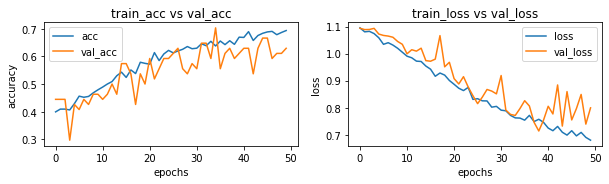

2/2 [==============================] - 1s 912ms/step - loss: 0.8067 - acc: 0.6000
Predictions:  [1 1 2 1 2 2 0 1 2 2 2 1 2 0 1 0 0 0 1 0 1 2 2 1 2 0 2 2 1 2 2 1 2 0 1 0 2
 2 0 0 1 2 2 0 0]
Actual:  [1 1 2 0 2 2 0 2 1 1 0 0 2 0 1 0 0 0 1 0 0 1 0 0 2 0 1 2 1 1 2 1 1 1 1 0 1
 2 0 1 1 0 1 0 0]


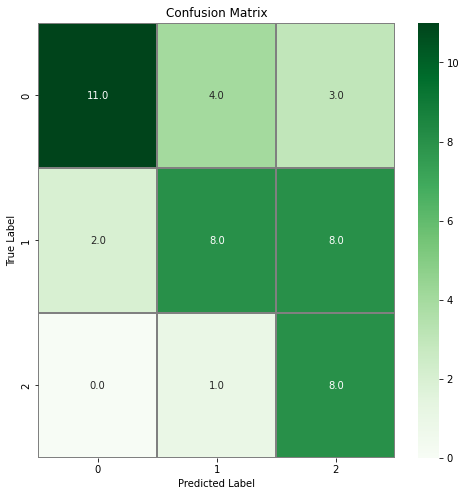

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.61      0.71        18
           1       0.62      0.44      0.52        18
           2       0.42      0.89      0.57         9

    accuracy                           0.60        45
   macro avg       0.63      0.65      0.60        45
weighted avg       0.67      0.60      0.60        45

[[0.09018624 0.5710463  0.33876747]
 [0.08392978 0.5193453  0.39672494]
 [0.00519775 0.19119753 0.8036047 ]
 [0.34269306 0.5248577  0.13244918]
 [0.10026555 0.06579789 0.8339366 ]
 [0.02354456 0.45666    0.5197955 ]
 [0.51391387 0.34344646 0.14263967]
 [0.04507715 0.77130276 0.18362008]
 [0.00698838 0.26029179 0.7327199 ]
 [0.06157626 0.28929994 0.64912385]
 [0.09376527 0.06544886 0.84078586]
 [0.14487965 0.7909864  0.06413393]
 [0.00742542 0.1227275  0.8698471 ]
 [0.92042226 0.02920678 0.05037088]
 [0.04027919 0.80738014 0.1523407 ]
 [0.7778787  0.14745697 0.07466432]
 [0.67291796 0.2656

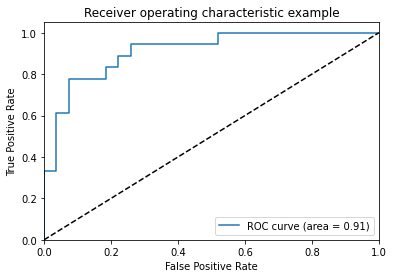

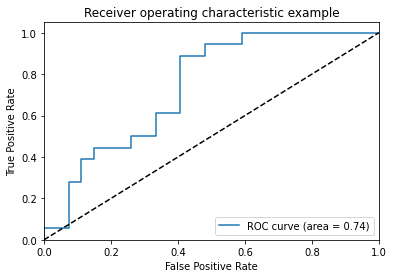

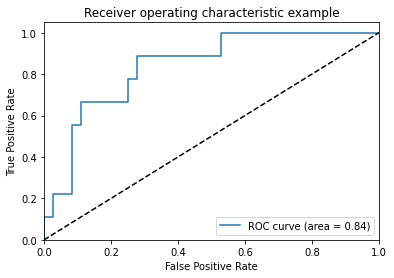

In [33]:
plot_accuracy_loss(history_CNN_RMS)
pred_labels, test_labels = make_predictions(CNNmodel_RMS, test_X, test_Y)
print("Predictions: ", pred_labels)
print("Actual: ", test_labels)
plot_confusion_matrix(test_labels, pred_labels)
print_classification_report(test_labels, pred_labels)
plot_AUC_ROC(CNNmodel_RMS, test_X, test_Y)

### **Testing CNN model on PotsDam dataset**

10/10 [==============================] - 1s 141ms/step - loss: 1.3213 - acc: 0.4400
[2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 1 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 2
 2 2 0 0 2 2 0 2 2 2 0 2 2 0 0 2 2 2 2 0 2 2 2 2 2 2 0 1 2 0 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 0 0 2 2 2
 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 2 1 2 2 2 2 0 2 2 0 0 0 2
 2 0 2 0 0 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2
 2 0 0 2 2 2 2 2 2 0 0 2 2 2 2 0 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 0 2 2 0 0 0 2 2 2 2 2 2 2 2 0 1 2
 2 2 2 0 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2
 0 2 2 2]
[1 0 2 2 1 0 2 2 0 2 2 2 2 1 2 0 0 0 2 0 1 1 0 1 2 1 2 1 2 0 1 2 0 0 0 0 1
 0 0 2 0 0 1 0 1 0 1 0 2 0 0 0 1 2 1 1 0 1 0 2 0 2 2 1 0 1 0 0 0 0 0 2 0 1
 2 1 1 1 2 0 2 1 1 1 1 2 2 0 1 1 1 1 0 1 0 2 1 2 2 2 1 2 1 2 0 2 0 0 1 2 1
 2 2 2 1 0 0 0 2 0 1 2 1 2 1 2 1 1 1 0 2 1 2 1 1 2 0 0 1 0 2 0 2 1 0 1 0 1
 2 0 2

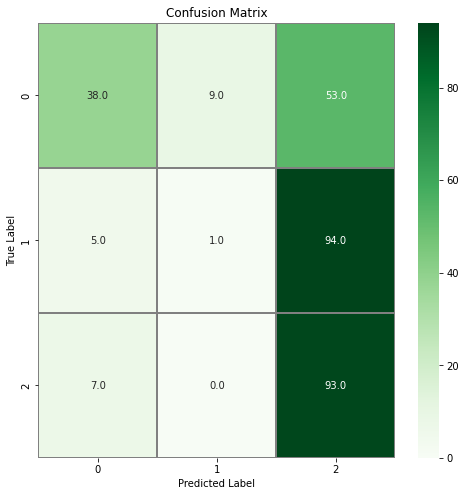

In [34]:
CNNmodel_RMS = tf.keras.models.load_model('./CNN-RMSProp-50epochs-mod2')
test_loss = CNNmodel_RMS.evaluate(train_X_potsdam, train_Y_potsdam)
predictions = CNNmodel_RMS.predict(train_X_potsdam)
pred_labels = np.argmax(predictions, axis = 1)
test_labels = np.argmax(train_Y_potsdam, axis = 1)
print(pred_labels)
print(test_labels)
print(test_loss)
print_classification_report(test_labels, pred_labels)
plot_confusion_matrix(test_labels, pred_labels)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2]


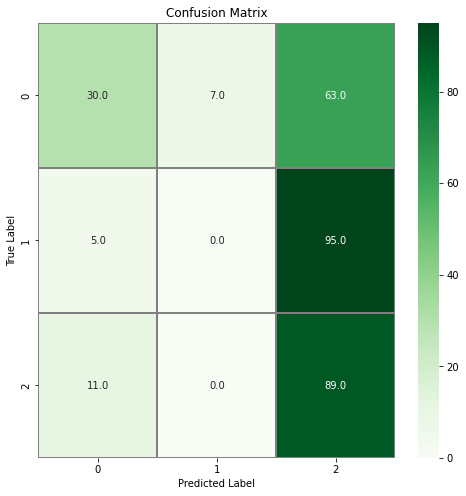

Classification Report: 
              precision    recall  f1-score   support

           0       0.65      0.30      0.41       100
           1       0.00      0.00      0.00       100
           2       0.36      0.89      0.51       100

    accuracy                           0.40       300
   macro avg       0.34      0.40      0.31       300
weighted avg       0.34      0.40      0.31       300

0.39666666666666667


In [35]:
acc, yhats = tta_evaluate_model(CNNmodel_RMS, train_X_potsdam, train_Y_potsdam)
print(acc)

### **ResNet50**

* Optimizer - RMSProp
* Learning rate - 0.00001
* Epochs - 50
* Batch size- 8

In [36]:
ResNet50_model = keras.applications.resnet50.ResNet50()
image_size = 256
input_shape = (image_size, image_size, 3)

pre_trained_model_finetuning = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")
pre_trained_model_finetuning.trainable = True

94781440/94765736 [==============================] - 1s 0us/step


In [37]:
last_layer = pre_trained_model_finetuning.get_layer('conv5_block3_out')
last_output = last_layer.output

x = GlobalMaxPooling2D()(last_output)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = keras.layers.Dense(3, activation = 'softmax')(x)

ResNet50_finetuning_bs8 = Model(pre_trained_model_finetuning.input, x)

ResNet50_finetuning_bs8.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [38]:
# checkpoint: save best model during the training 
filepath = "./ResNet50-50epochs-bs8-mod2"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate = 0.00001, decay = 1e-7)

# Let's train the model using RMSprop
ResNet50_finetuning_bs8.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc']) 

In [39]:
history_ResNet50_finetuning_bs8 = ResNet50_finetuning_bs8.fit(data_generation.flow(train_X, train_Y, batch_size = 8),
                                steps_per_epoch = train_X.shape[0] // 8,
                                epochs = 50,
                                validation_data = (val_X, val_Y),
                                callbacks = [callbacks_list])

Epoch 1/50
127/127 [==============================] - 28s 143ms/step - loss: 1.8746 - acc: 0.3297 - val_loss: 1.1019 - val_acc: 0.4074

Epoch 00001: val_acc improved from -inf to 0.40741, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
127/127 [==============================] - 17s 136ms/step - loss: 1.4734 - acc: 0.3612 - val_loss: 1.3864 - val_acc: 0.4630

Epoch 00002: val_acc improved from 0.40741 to 0.46296, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/50
127/127 [==============================] - 17s 137ms/step - loss: 1.3335 - acc: 0.3799 - val_loss: 1.7601 - val_acc: 0.3148

Epoch 00003: val_acc did not improve from 0.46296
Epoch 4/50
127/127 [==============================] - 17s 135ms/step - loss: 1.2164 - acc: 0.4055 - val_loss: 1.7509 - val_acc: 0.3704

Epoch 00004: val_acc did not improve from 0.46296
Epoch 5/50
127/127 [==============================] - 17s 136ms/step - loss: 1.1921 - acc: 0.4104 - val_loss: 1.6771 - val_acc: 0.2593

Epoch 00005: val_acc did not improve from 0.46296
Epoch 6/50
127/127 [==============================] - 17s 135ms/step - loss: 1.0999 - acc: 0.4370 - val_loss: 1.2413 - val_acc: 0.3333

Epoch 00006: val_acc did not improve from 0.46296
Epoch 7/50
127/127 [==============================] - 17s 135ms/step - loss: 1.0417 - acc: 0.4921 - val_loss: 0.9691 - val_acc: 0.6111

Epoch 00007: val_acc improved from 0.46296 to 0.61111, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/50
127/127 [==============================] - 17s 131ms/step - loss: 1.0080 - acc: 0.5000 - val_loss: 0.9023 - val_acc: 0.6481

Epoch 00008: val_acc improved from 0.61111 to 0.64815, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/50
127/127 [==============================] - 18s 138ms/step - loss: 1.0386 - acc: 0.4783 - val_loss: 0.8874 - val_acc: 0.7037

Epoch 00009: val_acc improved from 0.64815 to 0.70370, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/50
127/127 [==============================] - 17s 137ms/step - loss: 0.9770 - acc: 0.5226 - val_loss: 0.8290 - val_acc: 0.6296

Epoch 00010: val_acc did not improve from 0.70370
Epoch 11/50
127/127 [==============================] - 17s 134ms/step - loss: 0.9423 - acc: 0.5492 - val_loss: 0.7917 - val_acc: 0.6481

Epoch 00011: val_acc did not improve from 0.70370
Epoch 12/50
127/127 [==============================] - 17s 136ms/step - loss: 0.8839 - acc: 0.5866 - val_loss: 0.7144 - val_acc: 0.7222

Epoch 00012: val_acc improved from 0.70370 to 0.72222, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/50
127/127 [==============================] - 17s 134ms/step - loss: 0.7705 - acc: 0.6339 - val_loss: 0.6471 - val_acc: 0.7778

Epoch 00013: val_acc improved from 0.72222 to 0.77778, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/50
127/127 [==============================] - 17s 136ms/step - loss: 0.7338 - acc: 0.6644 - val_loss: 0.6162 - val_acc: 0.7778

Epoch 00014: val_acc did not improve from 0.77778
Epoch 15/50
127/127 [==============================] - 17s 134ms/step - loss: 0.6784 - acc: 0.6988 - val_loss: 0.5249 - val_acc: 0.8148

Epoch 00015: val_acc improved from 0.77778 to 0.81481, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/50
127/127 [==============================] - 17s 136ms/step - loss: 0.6252 - acc: 0.7244 - val_loss: 0.5166 - val_acc: 0.7963

Epoch 00016: val_acc did not improve from 0.81481
Epoch 17/50
127/127 [==============================] - 17s 134ms/step - loss: 0.6356 - acc: 0.7234 - val_loss: 0.4631 - val_acc: 0.8333

Epoch 00017: val_acc improved from 0.81481 to 0.83333, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/50
127/127 [==============================] - 17s 132ms/step - loss: 0.5453 - acc: 0.7638 - val_loss: 0.4504 - val_acc: 0.8333

Epoch 00018: val_acc did not improve from 0.83333
Epoch 19/50
127/127 [==============================] - 17s 131ms/step - loss: 0.5756 - acc: 0.7677 - val_loss: 0.3891 - val_acc: 0.8333

Epoch 00019: val_acc did not improve from 0.83333
Epoch 20/50
127/127 [==============================] - 18s 139ms/step - loss: 0.5110 - acc: 0.7923 - val_loss: 0.4097 - val_acc: 0.8704

Epoch 00020: val_acc improved from 0.83333 to 0.87037, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/50
127/127 [==============================] - 18s 138ms/step - loss: 0.5135 - acc: 0.7904 - val_loss: 0.3988 - val_acc: 0.8519

Epoch 00021: val_acc did not improve from 0.87037
Epoch 22/50
127/127 [==============================] - 17s 136ms/step - loss: 0.4737 - acc: 0.8297 - val_loss: 0.3853 - val_acc: 0.8704

Epoch 00022: val_acc did not improve from 0.87037
Epoch 23/50
127/127 [==============================] - 17s 135ms/step - loss: 0.4785 - acc: 0.8091 - val_loss: 0.3257 - val_acc: 0.8889

Epoch 00023: val_acc improved from 0.87037 to 0.88889, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/50
127/127 [==============================] - 17s 135ms/step - loss: 0.4459 - acc: 0.8278 - val_loss: 0.3418 - val_acc: 0.8889

Epoch 00024: val_acc did not improve from 0.88889
Epoch 25/50
127/127 [==============================] - 18s 138ms/step - loss: 0.4300 - acc: 0.8317 - val_loss: 0.3334 - val_acc: 0.8889

Epoch 00025: val_acc did not improve from 0.88889
Epoch 26/50
127/127 [==============================] - 17s 132ms/step - loss: 0.3837 - acc: 0.8484 - val_loss: 0.3393 - val_acc: 0.8704

Epoch 00026: val_acc did not improve from 0.88889
Epoch 27/50
127/127 [==============================] - 18s 137ms/step - loss: 0.3879 - acc: 0.8474 - val_loss: 0.3647 - val_acc: 0.8889

Epoch 00027: val_acc did not improve from 0.88889
Epoch 28/50
127/127 [==============================] - 17s 131ms/step - loss: 0.3510 - acc: 0.8612 - val_loss: 0.3751 - val_acc: 0.8519

Epoch 00028: val_acc did not improve from 0.88889
Epoch 29/50
127/127 [==============================] - 18s 138ms/

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/50
127/127 [==============================] - 17s 136ms/step - loss: 0.2355 - acc: 0.9094 - val_loss: 0.2825 - val_acc: 0.9074

Epoch 00034: val_acc did not improve from 0.90741
Epoch 35/50
127/127 [==============================] - 17s 133ms/step - loss: 0.2450 - acc: 0.9154 - val_loss: 0.3077 - val_acc: 0.9259

Epoch 00035: val_acc improved from 0.90741 to 0.92593, saving model to ./ResNet50-50epochs-bs8-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 36/50
127/127 [==============================] - 17s 135ms/step - loss: 0.2323 - acc: 0.9104 - val_loss: 0.2549 - val_acc: 0.9074

Epoch 00036: val_acc did not improve from 0.92593
Epoch 37/50
127/127 [==============================] - 17s 135ms/step - loss: 0.2248 - acc: 0.9213 - val_loss: 0.3019 - val_acc: 0.9074

Epoch 00037: val_acc did not improve from 0.92593
Epoch 38/50
127/127 [==============================] - 17s 133ms/step - loss: 0.2120 - acc: 0.9311 - val_loss: 0.3274 - val_acc: 0.9259

Epoch 00038: val_acc did not improve from 0.92593
Epoch 39/50
127/127 [==============================] - 17s 134ms/step - loss: 0.2389 - acc: 0.9242 - val_loss: 0.2317 - val_acc: 0.8889

Epoch 00039: val_acc did not improve from 0.92593
Epoch 40/50
127/127 [==============================] - 17s 136ms/step - loss: 0.2132 - acc: 0.9203 - val_loss: 0.3026 - val_acc: 0.9074

Epoch 00040: val_acc did not improve from 0.92593
Epoch 41/50
127/127 [==============================] - 17s 134ms/

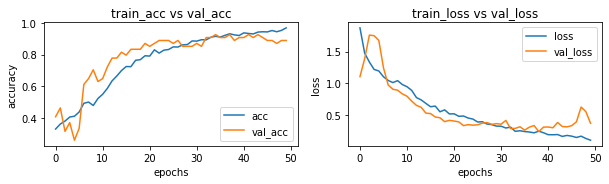

2/2 [==============================] - 0s 206ms/step - loss: 0.7123 - acc: 0.8889
Predictions:  [1 0 2 0 2 2 1 2 1 1 0 0 2 0 1 0 0 0 1 1 1 1 0 1 2 0 1 2 1 1 2 1 1 1 1 0 1
 2 0 1 1 0 1 0 0]
Actual:  [1 1 2 0 2 2 0 2 1 1 0 0 2 0 1 0 0 0 1 0 0 1 0 0 2 0 1 2 1 1 2 1 1 1 1 0 1
 2 0 1 1 0 1 0 0]


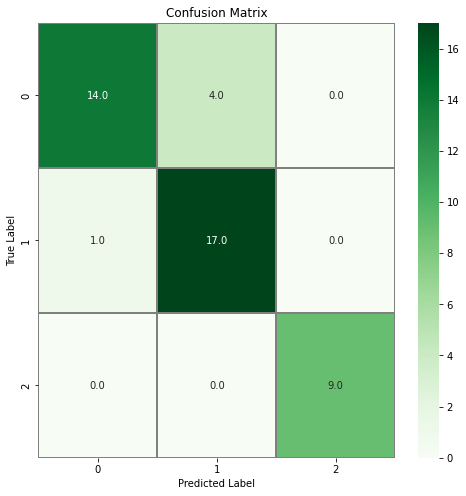

Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        18
           1       0.81      0.94      0.87        18
           2       1.00      1.00      1.00         9

    accuracy                           0.89        45
   macro avg       0.91      0.91      0.91        45
weighted avg       0.90      0.89      0.89        45

[[1.75878645e-09 1.00000000e+00 1.54841778e-10]
 [9.94238377e-01 5.71737718e-03 4.41809934e-05]
 [2.15414707e-06 2.55986515e-06 9.99995232e-01]
 [7.09208846e-01 2.90690839e-01 1.00316516e-04]
 [3.26493610e-09 5.69068037e-09 1.00000000e+00]
 [1.22684414e-05 4.94221691e-03 9.95045543e-01]
 [3.22360575e-04 9.99677539e-01 9.88261135e-08]
 [8.56895110e-12 7.97178781e-11 1.00000000e+00]
 [2.03717832e-06 9.99997973e-01 2.02767882e-08]
 [4.77441718e-05 9.99614835e-01 3.37308418e-04]
 [9.99965072e-01 3.35651093e-05 1.25815200e-06]
 [9.99291897e-01 6.93195034e-04 1.49246243e-05]
 [3.84798828e-13 1.

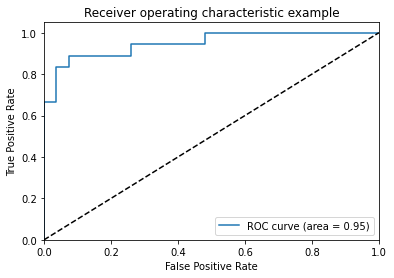

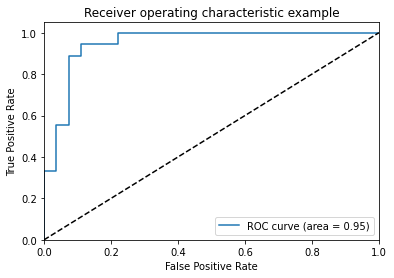

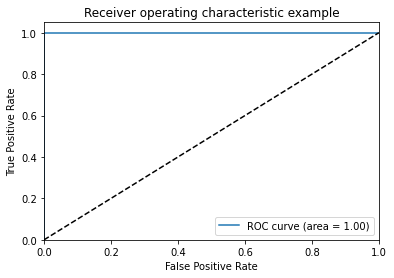

In [40]:
plot_accuracy_loss(history_ResNet50_finetuning_bs8)
pred_labels, test_labels = make_predictions(ResNet50_finetuning_bs8, test_X, test_Y)
print("Predictions: ", pred_labels)
print("Actual: ", test_labels)
plot_confusion_matrix(test_labels, pred_labels)
print_classification_report(test_labels, pred_labels)
plot_AUC_ROC(ResNet50_finetuning_bs8, test_X, test_Y)

### **ResNet testing on PotsDam Dataset**

10/10 [==============================] - 2s 87ms/step - loss: 0.9476 - acc: 0.6600
[0 0 2 1 0 0 2 0 0 0 2 2 2 0 2 1 0 0 2 0 1 0 1 0 2 1 2 0 0 1 0 1 0 0 0 0 1
 0 0 0 0 0 1 1 0 0 0 0 2 0 0 0 0 1 1 0 0 1 0 0 0 2 2 1 0 0 0 0 0 1 0 2 0 0
 2 0 1 1 1 0 0 1 0 0 0 2 0 0 1 0 1 1 0 0 0 2 0 2 0 0 0 2 0 2 0 2 0 0 1 1 1
 1 2 2 0 0 0 0 2 0 1 0 2 2 1 2 1 1 0 0 2 1 0 1 1 2 0 0 1 0 2 0 0 0 1 0 0 1
 1 0 0 0 1 0 0 0 2 0 2 1 1 0 0 0 1 2 2 2 2 0 0 0 0 0 2 0 1 0 0 0 0 0 0 2 1
 2 0 0 0 2 1 1 2 2 0 1 2 2 0 0 1 0 0 0 0 0 0 2 1 0 0 0 1 1 2 1 1 1 1 2 1 2
 0 0 2 0 2 0 2 0 2 0 1 0 2 2 1 1 1 0 1 0 0 2 1 1 1 0 1 0 1 0 1 2 0 0 0 1 2
 0 2 0 0 0 0 0 0 1 2 0 1 0 0 0 2 1 2 1 0 2 0 0 0 2 2 0 1 1 0 0 0 1 0 0 0 0
 0 2 0 0]
[1 0 2 2 1 0 2 2 0 2 2 2 2 1 2 0 0 0 2 0 1 1 0 1 2 1 2 1 2 0 1 2 0 0 0 0 1
 0 0 2 0 0 1 0 1 0 1 0 2 0 0 0 1 2 1 1 0 1 0 2 0 2 2 1 0 1 0 0 0 0 0 2 0 1
 2 1 1 1 2 0 2 1 1 1 1 2 2 0 1 1 1 1 0 1 0 2 1 2 2 2 1 2 1 2 0 2 0 0 1 2 1
 2 2 2 1 0 0 0 2 0 1 2 1 2 1 2 1 1 1 0 2 1 2 1 1 2 0 0 1 0 2 0 2 1 0 1 0 1
 2 0 2 

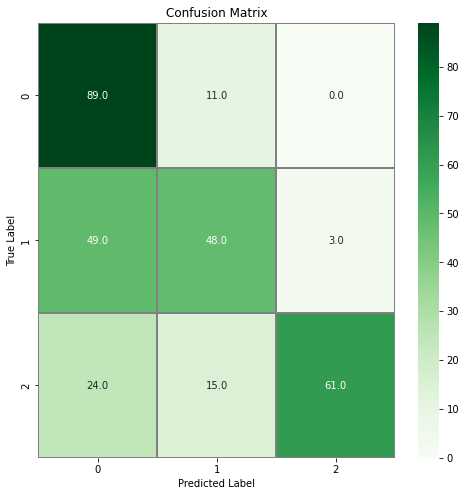

In [41]:
ResNet50_finetuning_bs8 = tf.keras.models.load_model('./ResNet50-50epochs-bs8-mod2')
test_loss = ResNet50_finetuning_bs8.evaluate(train_X_potsdam, train_Y_potsdam)
predictions = ResNet50_finetuning_bs8.predict(train_X_potsdam)
pred_labels = np.argmax(predictions, axis = 1)
test_labels = np.argmax(train_Y_potsdam, axis = 1)
print(pred_labels)
print(test_labels)
print(test_loss)
print_classification_report(test_labels, pred_labels)
plot_confusion_matrix(test_labels, pred_labels)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[0, 0, 2, 1, 0, 0, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 1, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 2, 1, 2, 0, 2, 0, 1, 1, 1, 1, 1, 2, 2, 0, 1, 0, 0, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 2, 0, 0, 1, 1, 2, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 1, 2, 0, 2, 1, 1, 0, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 2, 2, 0, 1, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 0, 2, 0, 1, 2, 1, 0, 0, 1, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 0, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0]


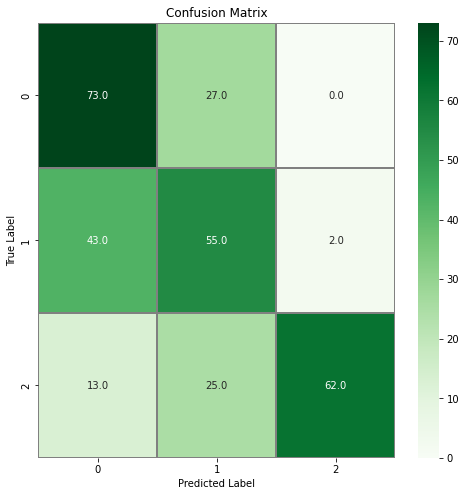

Classification Report: 
              precision    recall  f1-score   support

           0       0.57      0.73      0.64       100
           1       0.51      0.55      0.53       100
           2       0.97      0.62      0.76       100

    accuracy                           0.63       300
   macro avg       0.68      0.63      0.64       300
weighted avg       0.68      0.63      0.64       300

0.6333333333333333


In [42]:
acc, yhats = tta_evaluate_model(ResNet50_finetuning_bs8, train_X_potsdam, train_Y_potsdam)
print(acc)

### **EfficientNetB4 with finetuning**

* Optimizer - RMSProp
* Learning rate - 0.00001
* Batch size - 16
* Epochs - 50

In [43]:
image_size = 256
input_shape = (image_size, image_size, 3)
EfficientNetModel = EfficientNetB4(input_shape=input_shape, include_top = False, weights='imagenet')
EfficientNetModel.trainable = True

71696384/71686520 [==============================] - 1s 0us/step


In [44]:
last_layer = EfficientNetModel.get_layer('top_bn')
last_output = last_layer.output

x = GlobalMaxPooling2D()(last_output)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = keras.layers.Dense(3, activation = 'softmax')(x)

EfficientNetB4_finetuning_RMS_bs16 = Model(EfficientNetModel.input, x)

EfficientNetB4_finetuning_RMS_bs16.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [45]:
# checkpoint: save best model during the training 
filepath = "./EfficientNetB4-50epochs-bs16-RMS-mod2"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

# initiate RMS optimizer
opt = keras.optimizers.RMSprop(learning_rate = 0.00001, decay = 1e-7)

# Let's train the model using RMS
EfficientNetB4_finetuning_RMS_bs16.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])  

In [46]:
history_EfficientNetB4_finetuning_RMS_bs16 = EfficientNetB4_finetuning_RMS_bs16.fit(data_generation.flow(train_X, train_Y, batch_size = 16),
                                steps_per_epoch = train_X.shape[0] // 16,
                                epochs = 50,
                                validation_data = (val_X, val_Y),
                                callbacks = [callbacks_list])

Epoch 1/50
63/63 [==============================] - 53s 436ms/step - loss: 1.3792 - acc: 0.3270 - val_loss: 1.2709 - val_acc: 0.4444

Epoch 00001: val_acc improved from -inf to 0.44444, saving model to ./EfficientNetB4-50epochs-bs16-RMS-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
63/63 [==============================] - 24s 379ms/step - loss: 1.2411 - acc: 0.3820 - val_loss: 1.1252 - val_acc: 0.4444

Epoch 00002: val_acc did not improve from 0.44444
Epoch 3/50
63/63 [==============================] - 24s 373ms/step - loss: 1.1726 - acc: 0.3630 - val_loss: 1.0922 - val_acc: 0.4074

Epoch 00003: val_acc did not improve from 0.44444
Epoch 4/50
63/63 [==============================] - 24s 381ms/step - loss: 1.1280 - acc: 0.3950 - val_loss: 1.0822 - val_acc: 0.4444

Epoch 00004: val_acc did not improve from 0.44444
Epoch 5/50
63/63 [==============================] - 24s 380ms/step - loss: 1.1216 - acc: 0.4090 - val_loss: 1.0473 - val_acc: 0.4815

Epoch 00005: val_acc improved from 0.44444 to 0.48148, saving model to ./EfficientNetB4-50epochs-bs16-RMS-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/50
63/63 [==============================] - 24s 374ms/step - loss: 1.1114 - acc: 0.3890 - val_loss: 1.0566 - val_acc: 0.4444

Epoch 00006: val_acc did not improve from 0.48148
Epoch 7/50
63/63 [==============================] - 24s 382ms/step - loss: 1.0964 - acc: 0.4040 - val_loss: 1.0698 - val_acc: 0.4630

Epoch 00007: val_acc did not improve from 0.48148
Epoch 8/50
63/63 [==============================] - 24s 373ms/step - loss: 1.0763 - acc: 0.4260 - val_loss: 1.0610 - val_acc: 0.4815

Epoch 00008: val_acc did not improve from 0.48148
Epoch 9/50
63/63 [==============================] - 24s 381ms/step - loss: 1.0395 - acc: 0.4650 - val_loss: 1.0382 - val_acc: 0.4630

Epoch 00009: val_acc did not improve from 0.48148
Epoch 10/50
63/63 [==============================] - 24s 383ms/step - loss: 1.0542 - acc: 0.4480 - val_loss: 1.0415 - val_acc: 0.4630

Epoch 00010: val_acc did not improve from 0.48148
Epoch 11/50
63/63 [==============================] - 24s 382ms/step - loss: 1.0

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/50
63/63 [==============================] - 24s 382ms/step - loss: 1.0101 - acc: 0.4720 - val_loss: 1.0078 - val_acc: 0.5000

Epoch 00012: val_acc did not improve from 0.50000
Epoch 13/50
63/63 [==============================] - 24s 376ms/step - loss: 0.9989 - acc: 0.5010 - val_loss: 0.9687 - val_acc: 0.5556

Epoch 00013: val_acc improved from 0.50000 to 0.55556, saving model to ./EfficientNetB4-50epochs-bs16-RMS-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/50
63/63 [==============================] - 24s 378ms/step - loss: 0.9999 - acc: 0.4940 - val_loss: 0.9304 - val_acc: 0.5741

Epoch 00014: val_acc improved from 0.55556 to 0.57407, saving model to ./EfficientNetB4-50epochs-bs16-RMS-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/50
63/63 [==============================] - 24s 374ms/step - loss: 0.9589 - acc: 0.5270 - val_loss: 0.9620 - val_acc: 0.5556

Epoch 00015: val_acc did not improve from 0.57407
Epoch 16/50
63/63 [==============================] - 24s 382ms/step - loss: 0.9440 - acc: 0.5340 - val_loss: 0.8145 - val_acc: 0.7407

Epoch 00016: val_acc improved from 0.57407 to 0.74074, saving model to ./EfficientNetB4-50epochs-bs16-RMS-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/50
63/63 [==============================] - 24s 372ms/step - loss: 0.9195 - acc: 0.5400 - val_loss: 0.7914 - val_acc: 0.6667

Epoch 00017: val_acc did not improve from 0.74074
Epoch 18/50
63/63 [==============================] - 24s 381ms/step - loss: 0.9040 - acc: 0.5780 - val_loss: 0.7722 - val_acc: 0.7037

Epoch 00018: val_acc did not improve from 0.74074
Epoch 19/50
63/63 [==============================] - 24s 380ms/step - loss: 0.8414 - acc: 0.6060 - val_loss: 0.7578 - val_acc: 0.6667

Epoch 00019: val_acc did not improve from 0.74074
Epoch 20/50
63/63 [==============================] - 24s 381ms/step - loss: 0.8331 - acc: 0.6120 - val_loss: 0.8466 - val_acc: 0.6667

Epoch 00020: val_acc did not improve from 0.74074
Epoch 21/50
63/63 [==============================] - 24s 374ms/step - loss: 0.7977 - acc: 0.6550 - val_loss: 0.6494 - val_acc: 0.7778

Epoch 00021: val_acc improved from 0.74074 to 0.77778, saving model to ./EfficientNetB4-50epochs-bs16-RMS-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/50
63/63 [==============================] - 24s 382ms/step - loss: 0.7785 - acc: 0.6610 - val_loss: 0.7401 - val_acc: 0.7778

Epoch 00022: val_acc did not improve from 0.77778
Epoch 23/50
63/63 [==============================] - 24s 379ms/step - loss: 0.7430 - acc: 0.6680 - val_loss: 0.7314 - val_acc: 0.7222

Epoch 00023: val_acc did not improve from 0.77778
Epoch 24/50
63/63 [==============================] - 24s 373ms/step - loss: 0.7499 - acc: 0.6660 - val_loss: 0.5354 - val_acc: 0.8148

Epoch 00024: val_acc improved from 0.77778 to 0.81481, saving model to ./EfficientNetB4-50epochs-bs16-RMS-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/50
63/63 [==============================] - 24s 381ms/step - loss: 0.7235 - acc: 0.6810 - val_loss: 0.5751 - val_acc: 0.7593

Epoch 00025: val_acc did not improve from 0.81481
Epoch 26/50
63/63 [==============================] - 24s 371ms/step - loss: 0.6966 - acc: 0.6930 - val_loss: 0.4987 - val_acc: 0.7778

Epoch 00026: val_acc did not improve from 0.81481
Epoch 27/50
63/63 [==============================] - 24s 381ms/step - loss: 0.6534 - acc: 0.7260 - val_loss: 0.5626 - val_acc: 0.7963

Epoch 00027: val_acc did not improve from 0.81481
Epoch 28/50
63/63 [==============================] - 24s 386ms/step - loss: 0.6239 - acc: 0.7260 - val_loss: 0.4737 - val_acc: 0.8519

Epoch 00028: val_acc improved from 0.81481 to 0.85185, saving model to ./EfficientNetB4-50epochs-bs16-RMS-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 29/50
63/63 [==============================] - 24s 374ms/step - loss: 0.6313 - acc: 0.7240 - val_loss: 0.5341 - val_acc: 0.8148

Epoch 00029: val_acc did not improve from 0.85185
Epoch 30/50
63/63 [==============================] - 24s 383ms/step - loss: 0.6273 - acc: 0.7280 - val_loss: 0.5318 - val_acc: 0.8333

Epoch 00030: val_acc did not improve from 0.85185
Epoch 31/50
63/63 [==============================] - 24s 376ms/step - loss: 0.5870 - acc: 0.7760 - val_loss: 0.4188 - val_acc: 0.8333

Epoch 00031: val_acc did not improve from 0.85185
Epoch 32/50
63/63 [==============================] - 24s 381ms/step - loss: 0.5564 - acc: 0.7770 - val_loss: 0.4673 - val_acc: 0.8333

Epoch 00032: val_acc did not improve from 0.85185
Epoch 33/50
63/63 [==============================] - 24s 374ms/step - loss: 0.5414 - acc: 0.7720 - val_loss: 0.4222 - val_acc: 0.8519

Epoch 00033: val_acc did not improve from 0.85185
Epoch 34/50
63/63 [==============================] - 24s 382ms/step - loss:

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 41/50
63/63 [==============================] - 24s 372ms/step - loss: 0.4461 - acc: 0.8070 - val_loss: 0.4243 - val_acc: 0.7778

Epoch 00041: val_acc did not improve from 0.87037
Epoch 42/50
63/63 [==============================] - 24s 381ms/step - loss: 0.4381 - acc: 0.8260 - val_loss: 0.4468 - val_acc: 0.7778

Epoch 00042: val_acc did not improve from 0.87037
Epoch 43/50
63/63 [==============================] - 24s 372ms/step - loss: 0.4165 - acc: 0.8250 - val_loss: 0.4713 - val_acc: 0.7963

Epoch 00043: val_acc did not improve from 0.87037
Epoch 44/50
63/63 [==============================] - 24s 381ms/step - loss: 0.3916 - acc: 0.8450 - val_loss: 0.4862 - val_acc: 0.8704

Epoch 00044: val_acc did not improve from 0.87037
Epoch 45/50
63/63 [==============================] - 24s 385ms/step - loss: 0.4091 - acc: 0.8360 - val_loss: 0.3746 - val_acc: 0.8519

Epoch 00045: val_acc did not improve from 0.87037
Epoch 46/50
63/63 [==============================] - 24s 380ms/step - loss:

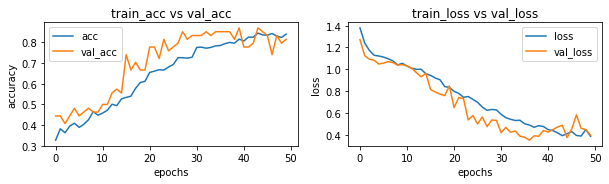

2/2 [==============================] - 0s 287ms/step - loss: 0.3617 - acc: 0.8444
Predictions:  [1 1 2 0 2 1 1 2 1 1 0 0 2 0 1 0 1 1 1 0 1 1 0 1 2 0 1 2 1 1 2 1 1 1 1 0 1
 2 0 0 1 0 1 0 0]
Actual:  [1 1 2 0 2 2 0 2 1 1 0 0 2 0 1 0 0 0 1 0 0 1 0 0 2 0 1 2 1 1 2 1 1 1 1 0 1
 2 0 1 1 0 1 0 0]


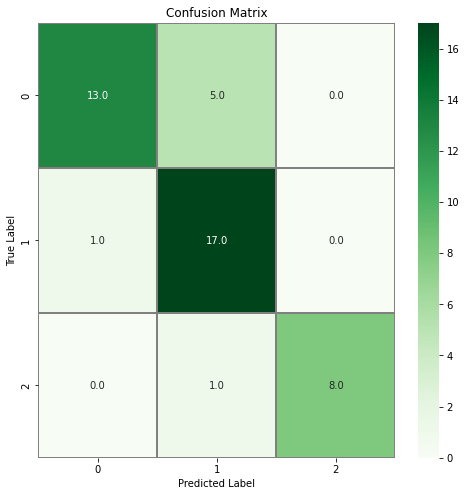

Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.72      0.81        18
           1       0.74      0.94      0.83        18
           2       1.00      0.89      0.94         9

    accuracy                           0.84        45
   macro avg       0.89      0.85      0.86        45
weighted avg       0.87      0.84      0.84        45

[[2.72676200e-02 9.31053221e-01 4.16791439e-02]
 [3.07034135e-01 6.70459092e-01 2.25068163e-02]
 [1.05433341e-03 7.76669709e-03 9.91178930e-01]
 [6.14488423e-01 3.61180127e-01 2.43315138e-02]
 [6.72409730e-03 1.29688252e-02 9.80307043e-01]
 [5.76640218e-02 9.33074951e-01 9.26102418e-03]
 [1.95258141e-01 7.91615009e-01 1.31268958e-02]
 [1.76472349e-05 1.02934675e-04 9.99879360e-01]
 [1.19304203e-03 9.98706102e-01 1.00897625e-04]
 [6.92033842e-02 9.21759307e-01 9.03731771e-03]
 [6.44986629e-01 3.35510314e-01 1.95030142e-02]
 [7.66628802e-01 2.31850520e-01 1.52063218e-03]
 [2.72744626e-04 8.

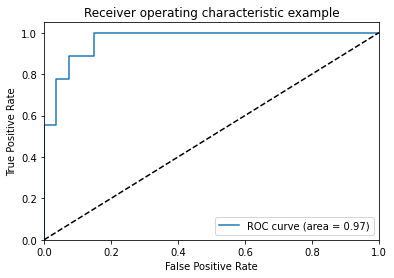

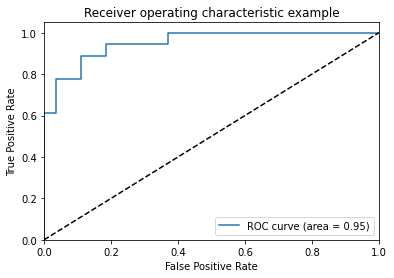

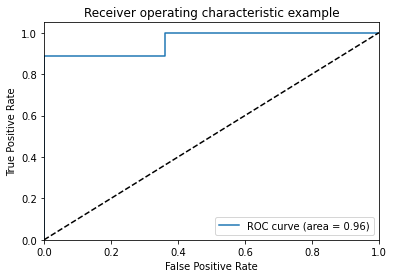

In [47]:
plot_accuracy_loss(history_EfficientNetB4_finetuning_RMS_bs16)
pred_labels, test_labels = make_predictions(EfficientNetB4_finetuning_RMS_bs16, test_X, test_Y)
print("Predictions: ", pred_labels)
print("Actual: ", test_labels)
plot_confusion_matrix(test_labels, pred_labels)
print_classification_report(test_labels, pred_labels)
plot_AUC_ROC(EfficientNetB4_finetuning_RMS_bs16, test_X, test_Y)

### **Testing EfficientNetB4-RMS Prop on PotsDam dataset**

10/10 [==============================] - 5s 145ms/step - loss: 0.8414 - acc: 0.6067
[0 1 2 1 1 0 2 2 1 2 2 2 2 0 2 0 0 0 0 0 1 2 1 0 2 1 2 0 2 0 0 1 0 0 1 0 0
 1 0 2 0 2 2 1 1 1 0 0 2 0 0 0 0 2 0 0 0 1 1 2 1 2 2 0 1 2 0 0 0 1 0 2 1 1
 2 0 1 1 2 0 1 0 2 1 0 2 2 1 1 0 1 1 0 0 1 2 2 2 1 1 0 2 0 2 0 2 1 0 1 2 0
 2 2 2 1 0 2 0 2 2 2 1 2 2 0 2 1 1 0 0 0 1 2 1 0 2 1 0 0 1 0 0 2 2 1 0 0 1
 1 0 0 0 1 2 1 0 2 0 2 1 2 0 1 1 1 2 2 2 2 0 0 2 2 1 2 0 2 0 2 0 0 2 1 2 1
 2 0 0 2 2 1 0 2 2 0 1 2 2 0 0 1 1 2 2 0 0 2 2 1 1 0 0 2 1 2 1 2 2 1 2 2 2
 1 2 2 1 2 0 2 2 2 0 1 2 1 1 1 2 1 0 1 1 1 2 1 2 2 0 1 0 2 1 1 0 2 0 0 1 2
 2 2 1 0 0 0 1 2 2 2 0 1 1 0 0 2 1 1 1 0 2 0 1 1 2 1 1 1 1 0 1 0 1 0 2 0 0
 0 2 2 0]
[1 0 2 2 1 0 2 2 0 2 2 2 2 1 2 0 0 0 2 0 1 1 0 1 2 1 2 1 2 0 1 2 0 0 0 0 1
 0 0 2 0 0 1 0 1 0 1 0 2 0 0 0 1 2 1 1 0 1 0 2 0 2 2 1 0 1 0 0 0 0 0 2 0 1
 2 1 1 1 2 0 2 1 1 1 1 2 2 0 1 1 1 1 0 1 0 2 1 2 2 2 1 2 1 2 0 2 0 0 1 2 1
 2 2 2 1 0 0 0 2 0 1 2 1 2 1 2 1 1 1 0 2 1 2 1 1 2 0 0 1 0 2 0 2 1 0 1 0 1
 2 0 2

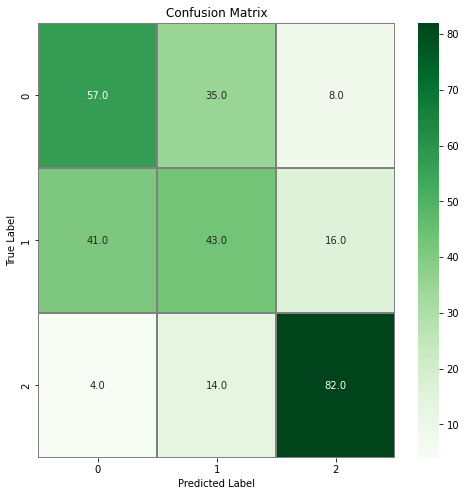

In [48]:
EfficientNetB4_finetuning_RMS_bs16 = tf.keras.models.load_model('./EfficientNetB4-50epochs-bs16-RMS-mod2')
test_loss = EfficientNetB4_finetuning_RMS_bs16.evaluate(train_X_potsdam, train_Y_potsdam)
predictions = EfficientNetB4_finetuning_RMS_bs16.predict(train_X_potsdam)
pred_labels = np.argmax(predictions, axis = 1)
test_labels = np.argmax(train_Y_potsdam, axis = 1)
print(pred_labels)
print(test_labels)
print(test_loss)
print_classification_report(test_labels, pred_labels)
plot_confusion_matrix(test_labels, pred_labels)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1, 1, 2, 1, 1, 0, 1, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 2, 2, 1, 2, 1, 1, 0, 2, 0, 1, 0, 1, 2, 1, 0, 0, 1, 1, 2, 1, 2, 0, 1, 1, 1, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 1, 0, 1, 1, 1, 0, 0, 2, 2, 2, 2, 1, 0, 2, 0, 1, 0, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 1, 2, 1, 2, 1, 2, 0, 0, 2, 2, 2, 0, 0, 2, 1, 1, 0, 2, 2, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 1, 2, 0, 0, 1, 1, 0, 2, 1, 2, 2, 0, 0, 2, 1, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2, 1, 2, 0, 0, 2, 2, 1, 1, 2, 2, 0, 1, 2, 2, 0, 0, 0, 1, 2, 2, 0, 1, 0, 2, 2, 0, 1, 0, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 2, 1, 2, 2, 0, 1, 0, 1, 2, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 2, 2, 1]


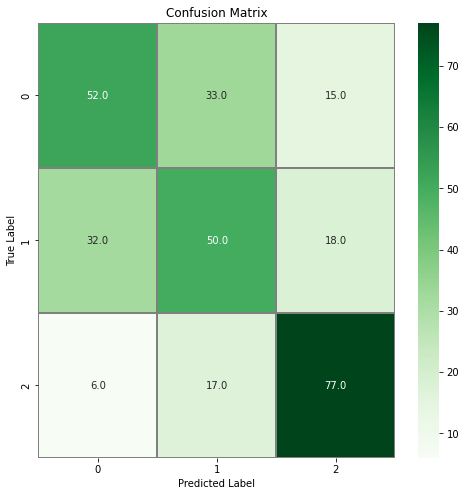

Classification Report: 
              precision    recall  f1-score   support

           0       0.58      0.52      0.55       100
           1       0.50      0.50      0.50       100
           2       0.70      0.77      0.73       100

    accuracy                           0.60       300
   macro avg       0.59      0.60      0.59       300
weighted avg       0.59      0.60      0.59       300

0.5966666666666667


In [49]:
acc, yhats = tta_evaluate_model(EfficientNetB4_finetuning_RMS_bs16, train_X_potsdam, train_Y_potsdam)
print(acc)

### **EfficientNetB4**

* Optimizer - Adam
* Learning rate - 0.00001
* Batch size - 16
* Epochs - 50

In [50]:
image_size = 256
input_shape = (image_size, image_size, 3)
EfficientNetModel = EfficientNetB4(input_shape=input_shape, include_top = False, weights='imagenet')
EfficientNetModel.trainable = True

In [51]:
last_layer = EfficientNetModel.get_layer('top_bn')
last_output = last_layer.output

x = GlobalMaxPooling2D()(last_output)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = keras.layers.Dense(3, activation = 'softmax')(x)

EfficientNetB4_finetuning_Adam_bs16 = Model(EfficientNetModel.input, x)

In [52]:
# checkpoint: save best model during the training 
filepath = "./EfficientNetB4-50epochs-bs16-Adam-mod2"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

# initiate RMS optimizer
opt = keras.optimizers.Adam(learning_rate = 0.00001, decay = 1e-7)

# Let's train the model using Adam
EfficientNetB4_finetuning_Adam_bs16.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])  

In [53]:
history_EfficientNetB4_finetuning_Adam_bs16 = EfficientNetB4_finetuning_Adam_bs16.fit(data_generation.flow(train_X, train_Y, batch_size = 16),
                                steps_per_epoch = train_X.shape[0] // 16,
                                epochs = 50,
                                validation_data = (val_X, val_Y),
                                callbacks = [callbacks_list])

Epoch 1/50
63/63 [==============================] - 43s 413ms/step - loss: 1.4186 - acc: 0.3440 - val_loss: 1.1250 - val_acc: 0.4444

Epoch 00001: val_acc improved from -inf to 0.44444, saving model to ./EfficientNetB4-50epochs-bs16-Adam-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
63/63 [==============================] - 24s 371ms/step - loss: 1.2627 - acc: 0.3900 - val_loss: 1.1222 - val_acc: 0.4444

Epoch 00002: val_acc did not improve from 0.44444
Epoch 3/50
63/63 [==============================] - 23s 370ms/step - loss: 1.1829 - acc: 0.3790 - val_loss: 1.1471 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.44444
Epoch 4/50
63/63 [==============================] - 23s 362ms/step - loss: 1.1815 - acc: 0.3740 - val_loss: 1.2168 - val_acc: 0.3333

Epoch 00004: val_acc did not improve from 0.44444
Epoch 5/50
63/63 [==============================] - 24s 374ms/step - loss: 1.1432 - acc: 0.3950 - val_loss: 1.0880 - val_acc: 0.4259

Epoch 00005: val_acc did not improve from 0.44444
Epoch 6/50
63/63 [==============================] - 23s 363ms/step - loss: 1.0856 - acc: 0.4220 - val_loss: 1.1242 - val_acc: 0.3704

Epoch 00006: val_acc did not improve from 0.44444
Epoch 7/50
63/63 [==============================] - 24s 372ms/step - loss: 1.090

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/50
63/63 [==============================] - 24s 371ms/step - loss: 1.0599 - acc: 0.4310 - val_loss: 0.9863 - val_acc: 0.4444

Epoch 00009: val_acc did not improve from 0.48148
Epoch 10/50
63/63 [==============================] - 24s 373ms/step - loss: 1.0253 - acc: 0.4720 - val_loss: 0.9499 - val_acc: 0.5741

Epoch 00010: val_acc improved from 0.48148 to 0.57407, saving model to ./EfficientNetB4-50epochs-bs16-Adam-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/50
63/63 [==============================] - 23s 361ms/step - loss: 0.9970 - acc: 0.5040 - val_loss: 0.9524 - val_acc: 0.5556

Epoch 00011: val_acc did not improve from 0.57407
Epoch 12/50
63/63 [==============================] - 23s 368ms/step - loss: 0.9952 - acc: 0.5050 - val_loss: 0.8808 - val_acc: 0.6667

Epoch 00012: val_acc improved from 0.57407 to 0.66667, saving model to ./EfficientNetB4-50epochs-bs16-Adam-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/50
63/63 [==============================] - 23s 370ms/step - loss: 0.9530 - acc: 0.5250 - val_loss: 0.8717 - val_acc: 0.6667

Epoch 00013: val_acc did not improve from 0.66667
Epoch 14/50
63/63 [==============================] - 23s 368ms/step - loss: 0.9413 - acc: 0.5380 - val_loss: 0.8241 - val_acc: 0.7037

Epoch 00014: val_acc improved from 0.66667 to 0.70370, saving model to ./EfficientNetB4-50epochs-bs16-Adam-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/50
63/63 [==============================] - 24s 373ms/step - loss: 0.8909 - acc: 0.5820 - val_loss: 0.7109 - val_acc: 0.7222

Epoch 00015: val_acc improved from 0.70370 to 0.72222, saving model to ./EfficientNetB4-50epochs-bs16-Adam-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/50
63/63 [==============================] - 23s 368ms/step - loss: 0.8526 - acc: 0.6250 - val_loss: 0.6613 - val_acc: 0.7407

Epoch 00016: val_acc improved from 0.72222 to 0.74074, saving model to ./EfficientNetB4-50epochs-bs16-Adam-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/50
63/63 [==============================] - 24s 371ms/step - loss: 0.8136 - acc: 0.6350 - val_loss: 0.6180 - val_acc: 0.7407

Epoch 00017: val_acc did not improve from 0.74074
Epoch 18/50
63/63 [==============================] - 23s 366ms/step - loss: 0.7794 - acc: 0.6410 - val_loss: 0.5843 - val_acc: 0.7407

Epoch 00018: val_acc did not improve from 0.74074
Epoch 19/50
63/63 [==============================] - 24s 371ms/step - loss: 0.7520 - acc: 0.6570 - val_loss: 0.5463 - val_acc: 0.8148

Epoch 00019: val_acc improved from 0.74074 to 0.81481, saving model to ./EfficientNetB4-50epochs-bs16-Adam-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/50
63/63 [==============================] - 24s 371ms/step - loss: 0.7191 - acc: 0.6750 - val_loss: 0.4974 - val_acc: 0.7778

Epoch 00020: val_acc did not improve from 0.81481
Epoch 21/50
63/63 [==============================] - 23s 369ms/step - loss: 0.7112 - acc: 0.6890 - val_loss: 0.5111 - val_acc: 0.8333

Epoch 00021: val_acc improved from 0.81481 to 0.83333, saving model to ./EfficientNetB4-50epochs-bs16-Adam-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/50
63/63 [==============================] - 24s 373ms/step - loss: 0.7029 - acc: 0.6940 - val_loss: 0.5109 - val_acc: 0.7778

Epoch 00022: val_acc did not improve from 0.83333
Epoch 23/50
63/63 [==============================] - 23s 362ms/step - loss: 0.6450 - acc: 0.7310 - val_loss: 0.6012 - val_acc: 0.7593

Epoch 00023: val_acc did not improve from 0.83333
Epoch 24/50
63/63 [==============================] - 24s 370ms/step - loss: 0.5909 - acc: 0.7370 - val_loss: 0.4326 - val_acc: 0.8333

Epoch 00024: val_acc did not improve from 0.83333
Epoch 25/50
63/63 [==============================] - 23s 362ms/step - loss: 0.6057 - acc: 0.7470 - val_loss: 0.4197 - val_acc: 0.8333

Epoch 00025: val_acc did not improve from 0.83333
Epoch 26/50
63/63 [==============================] - 23s 370ms/step - loss: 0.5956 - acc: 0.7460 - val_loss: 0.3905 - val_acc: 0.8333

Epoch 00026: val_acc did not improve from 0.83333
Epoch 27/50
63/63 [==============================] - 23s 363ms/step - loss:

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/50
63/63 [==============================] - 24s 372ms/step - loss: 0.5250 - acc: 0.7780 - val_loss: 0.4491 - val_acc: 0.8333

Epoch 00028: val_acc did not improve from 0.85185
Epoch 29/50
63/63 [==============================] - 24s 372ms/step - loss: 0.5356 - acc: 0.7609 - val_loss: 0.4281 - val_acc: 0.8333

Epoch 00029: val_acc did not improve from 0.85185
Epoch 30/50
63/63 [==============================] - 23s 370ms/step - loss: 0.5464 - acc: 0.7660 - val_loss: 0.3677 - val_acc: 0.8704

Epoch 00030: val_acc improved from 0.85185 to 0.87037, saving model to ./EfficientNetB4-50epochs-bs16-Adam-mod2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/50
63/63 [==============================] - 24s 371ms/step - loss: 0.5006 - acc: 0.7840 - val_loss: 0.3815 - val_acc: 0.8704

Epoch 00031: val_acc did not improve from 0.87037
Epoch 32/50
63/63 [==============================] - 23s 367ms/step - loss: 0.5681 - acc: 0.7710 - val_loss: 0.4256 - val_acc: 0.8148

Epoch 00032: val_acc did not improve from 0.87037
Epoch 33/50
63/63 [==============================] - 23s 368ms/step - loss: 0.5208 - acc: 0.7780 - val_loss: 0.3902 - val_acc: 0.8704

Epoch 00033: val_acc did not improve from 0.87037
Epoch 34/50
63/63 [==============================] - 23s 366ms/step - loss: 0.4723 - acc: 0.7910 - val_loss: 0.3794 - val_acc: 0.8333

Epoch 00034: val_acc did not improve from 0.87037
Epoch 35/50
63/63 [==============================] - 23s 363ms/step - loss: 0.4963 - acc: 0.7860 - val_loss: 0.3341 - val_acc: 0.8704

Epoch 00035: val_acc did not improve from 0.87037
Epoch 36/50
63/63 [==============================] - 23s 367ms/step - loss:

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


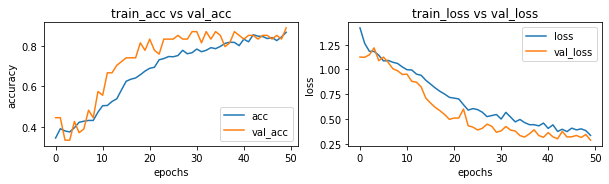

2/2 [==============================] - 0s 60ms/step - loss: 0.3434 - acc: 0.8889
Predictions:  [1 1 2 0 2 1 1 2 1 1 0 0 2 0 1 0 0 0 1 0 1 1 0 0 2 0 1 2 1 1 2 1 1 0 1 0 1
 2 0 0 1 0 1 0 0]
Actual:  [1 1 2 0 2 2 0 2 1 1 0 0 2 0 1 0 0 0 1 0 0 1 0 0 2 0 1 2 1 1 2 1 1 1 1 0 1
 2 0 1 1 0 1 0 0]


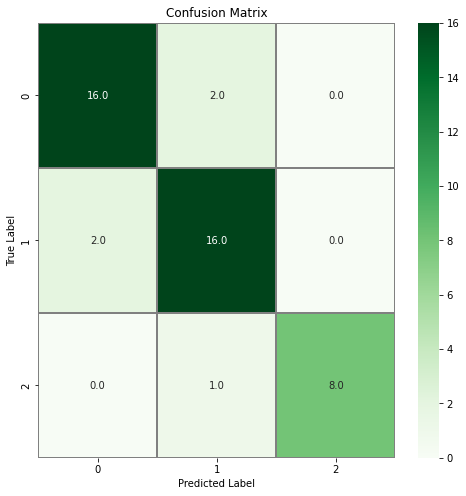

Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        18
           1       0.84      0.89      0.86        18
           2       1.00      0.89      0.94         9

    accuracy                           0.89        45
   macro avg       0.91      0.89      0.90        45
weighted avg       0.89      0.89      0.89        45

[[2.41781473e-02 9.74954307e-01 8.67635245e-04]
 [3.87426913e-01 5.86552024e-01 2.60210689e-02]
 [1.01873430e-03 2.12793960e-03 9.96853292e-01]
 [7.98576772e-01 1.95634037e-01 5.78914769e-03]
 [7.67906290e-03 2.34769774e-03 9.89973307e-01]
 [7.97845945e-02 8.14655125e-01 1.05560318e-01]
 [2.12317348e-01 7.83613622e-01 4.06905171e-03]
 [1.13044975e-04 2.33211307e-04 9.99653697e-01]
 [5.06574055e-03 9.94809270e-01 1.25032413e-04]
 [6.28282949e-02 9.32323813e-01 4.84784599e-03]
 [5.19013822e-01 4.80018198e-01 9.67943517e-04]
 [4.99032110e-01 4.91897643e-01 9.07019153e-03]
 [3.33464118e-06 6.

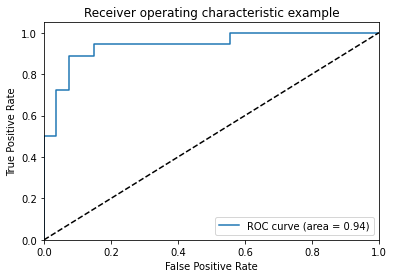

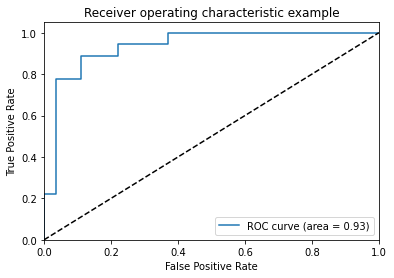

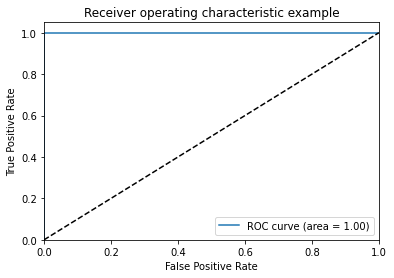

In [54]:
plot_accuracy_loss(history_EfficientNetB4_finetuning_Adam_bs16)
pred_labels, test_labels = make_predictions(EfficientNetB4_finetuning_Adam_bs16, test_X, test_Y)
print("Predictions: ", pred_labels)
print("Actual: ", test_labels)
plot_confusion_matrix(test_labels, pred_labels)
print_classification_report(test_labels, pred_labels)
plot_AUC_ROC(EfficientNetB4_finetuning_Adam_bs16, test_X, test_Y)

### **Testing EfficientNetB4-Adam on PotsDam dataset**

10/10 [==============================] - 5s 112ms/step - loss: 0.7469 - acc: 0.6533
[0 0 2 1 1 0 2 1 1 0 2 0 2 0 1 1 0 0 1 0 1 2 2 0 2 1 2 1 2 1 0 1 0 0 0 0 1
 1 0 0 0 1 0 1 1 0 0 0 2 0 0 0 1 1 1 0 0 1 1 0 1 2 2 1 0 1 0 0 0 2 0 2 0 0
 2 1 0 1 2 0 1 1 0 0 1 2 1 0 1 0 1 1 0 0 1 2 0 1 2 1 0 0 1 1 0 2 1 0 1 2 1
 2 2 2 0 0 0 0 2 0 2 0 1 2 1 2 1 0 1 0 2 0 0 1 0 2 0 0 1 0 0 0 2 1 1 1 0 1
 1 0 2 0 0 0 0 0 2 1 2 1 0 0 0 0 1 0 2 2 2 0 0 0 2 0 2 0 2 0 2 0 0 0 1 2 0
 2 1 1 1 2 0 1 1 2 0 1 2 2 0 0 0 2 0 2 0 0 0 2 1 0 0 0 1 2 2 0 1 2 0 2 0 2
 1 0 2 0 1 0 1 0 2 0 1 0 1 2 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 2
 1 2 1 0 0 0 0 0 2 2 0 1 0 0 0 2 1 2 1 0 2 1 0 1 2 2 1 0 1 0 1 0 1 1 1 0 0
 0 2 2 0]
[1 0 2 2 1 0 2 2 0 2 2 2 2 1 2 0 0 0 2 0 1 1 0 1 2 1 2 1 2 0 1 2 0 0 0 0 1
 0 0 2 0 0 1 0 1 0 1 0 2 0 0 0 1 2 1 1 0 1 0 2 0 2 2 1 0 1 0 0 0 0 0 2 0 1
 2 1 1 1 2 0 2 1 1 1 1 2 2 0 1 1 1 1 0 1 0 2 1 2 2 2 1 2 1 2 0 2 0 0 1 2 1
 2 2 2 1 0 0 0 2 0 1 2 1 2 1 2 1 1 1 0 2 1 2 1 1 2 0 0 1 0 2 0 2 1 0 1 0 1
 2 0 2

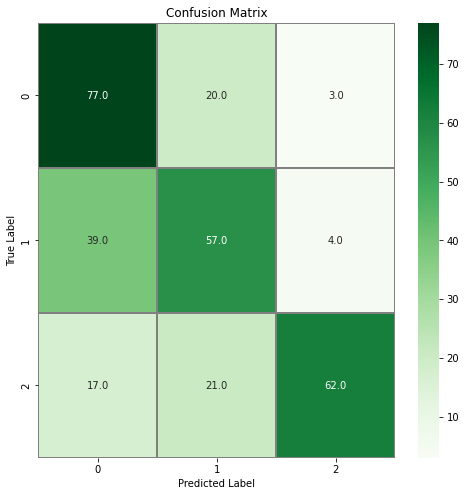

In [55]:
EfficientNetB4_finetuning_Adam_bs16 = tf.keras.models.load_model('./EfficientNetB4-50epochs-bs16-Adam-mod2')
test_loss = EfficientNetB4_finetuning_Adam_bs16.evaluate(train_X_potsdam, train_Y_potsdam)
predictions = EfficientNetB4_finetuning_Adam_bs16.predict(train_X_potsdam)
pred_labels = np.argmax(predictions, axis = 1)
test_labels = np.argmax(train_Y_potsdam, axis = 1)
print(pred_labels)
print(test_labels)
print(test_loss)
print_classification_report(test_labels, pred_labels)
plot_confusion_matrix(test_labels, pred_labels)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[0, 0, 2, 1, 0, 0, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 2, 2, 1, 1, 0, 1, 1, 0, 0, 1, 2, 0, 2, 2, 2, 0, 1, 1, 1, 0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0, 1, 1, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 1, 2, 0, 1, 0, 1, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 0, 0, 1, 2, 0, 2, 1, 1, 0, 2, 0, 1, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 1, 1, 2, 1, 0, 2, 1, 2, 1, 2, 0, 0, 2, 1, 1, 0, 1, 0, 2, 1, 1, 0, 2, 2, 0, 0, 1, 0, 1, 0, 0, 2, 1, 0, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 1, 0, 2, 1, 2, 1, 0, 2, 0, 0, 1, 0, 2, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 0]


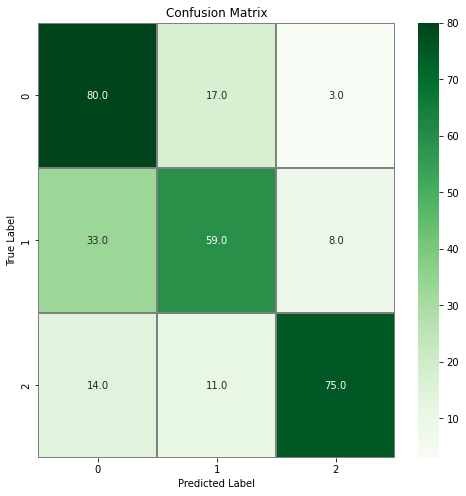

Classification Report: 
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       100
           1       0.68      0.59      0.63       100
           2       0.87      0.75      0.81       100

    accuracy                           0.71       300
   macro avg       0.73      0.71      0.71       300
weighted avg       0.73      0.71      0.71       300

0.7133333333333334


In [56]:
acc, yhats = tta_evaluate_model(EfficientNetB4_finetuning_Adam_bs16, train_X_potsdam, train_Y_potsdam)
print(acc)

### **VGG16**

* Optimizer - RMSProp
* Learning rate - 0.00001
* Batch size - 4
* Epochs - 50

In [57]:
image_size = 256
input_shape = (image_size, image_size, 3)

pre_trained_model_VGG = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
pre_trained_model_VGG.trainable = True

58900480/58889256 [==============================] - 0s 0us/step


In [58]:
last_layer = pre_trained_model_VGG.get_layer('block5_pool')
last_output = last_layer.output

x = GlobalMaxPooling2D()(last_output)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)

x = keras.layers.Dense(3, activation = 'softmax')(x)

VGG16_finetuning_RMS_bs4 = Model(pre_trained_model_VGG.input, x)

VGG16_finetuning_RMS_bs4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [59]:
# checkpoint: save best model during the training 
filepath = "./VGG16-50epochs-RMS-bs4-mod2"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

# initiate RMSProp optimizer
opt = keras.optimizers.RMSprop(learning_rate = 0.00001, decay = 1e-7)

# Let's train the model using RMSProp
VGG16_finetuning_RMS_bs4.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])  

In [60]:
history_VGG16_finetuning_RMS_bs4 = VGG16_finetuning_RMS_bs4.fit(data_generation.flow(train_X, train_Y, batch_size = 4),
                                steps_per_epoch = train_X.shape[0] // 4,
                                epochs = 50,
                                validation_data = (val_X, val_Y),
                                callbacks = [callbacks_list])

Epoch 1/50
254/254 [==============================] - 26s 94ms/step - loss: 1.0940 - acc: 0.3760 - val_loss: 1.0287 - val_acc: 0.4815

Epoch 00001: val_acc improved from -inf to 0.48148, saving model to ./VGG16-50epochs-RMS-bs4-mod2
Epoch 2/50
254/254 [==============================] - 18s 70ms/step - loss: 1.0516 - acc: 0.4380 - val_loss: 0.9546 - val_acc: 0.5741

Epoch 00002: val_acc improved from 0.48148 to 0.57407, saving model to ./VGG16-50epochs-RMS-bs4-mod2
Epoch 3/50
254/254 [==============================] - 18s 72ms/step - loss: 1.0109 - acc: 0.4911 - val_loss: 0.8331 - val_acc: 0.7037

Epoch 00003: val_acc improved from 0.57407 to 0.70370, saving model to ./VGG16-50epochs-RMS-bs4-mod2
Epoch 4/50
254/254 [==============================] - 18s 71ms/step - loss: 0.8868 - acc: 0.5984 - val_loss: 0.6495 - val_acc: 0.7963

Epoch 00004: val_acc improved from 0.70370 to 0.79630, saving model to ./VGG16-50epochs-RMS-bs4-mod2
Epoch 5/50
254/254 [==============================] - 18s 6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 20s 80ms/step - loss: 0.2887 - acc: 0.8868 - val_loss: 0.2905 - val_acc: 0.8889

Epoch 00015: val_acc did not improve from 0.88889
Epoch 16/50
254/254 [==============================] - 18s 73ms/step - loss: 0.2574 - acc: 0.9144 - val_loss: 0.2271 - val_acc: 0.9444

Epoch 00020: val_acc improved from 0.88889 to 0.94444, saving model to ./VGG16-50epochs-RMS-bs4-mod2
Epoch 21/50
254/254 [==============================] - 19s 73ms/step - loss: 0.2372 - acc: 0.9114 - val_loss: 0.2219 - val_acc: 0.8889

Epoch 00021: val_acc did not improve from 0.94444
Epoch 22/50
254/254 [==============================] - 18s 70ms/step - loss: 0.2222 - acc: 0.9252 - val_loss: 0.2061 - val_acc: 0.9259

Epoch 00022: val_acc did not improve from 0.94444
Epoch 23/50
254/254 [==============================] - 19s 73ms/step - loss: 0.2043 - acc: 0.9222 - val_loss: 0.2103 - val_acc: 0.9259

Epoch 00023: val_acc did not improve from 0.94444
Epoch 24/50
254/254 [==========

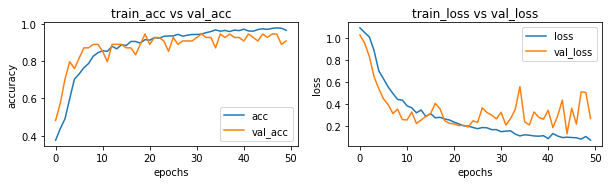

2/2 [==============================] - 2s 2s/step - loss: 0.4894 - acc: 0.8889
Predictions:  [1 0 2 0 2 1 0 2 1 1 0 0 2 0 1 0 0 0 1 0 1 1 0 0 2 0 1 2 1 1 2 1 1 0 1 0 1
 2 0 0 1 0 1 0 0]
Actual:  [1 1 2 0 2 2 0 2 1 1 0 0 2 0 1 0 0 0 1 0 0 1 0 0 2 0 1 2 1 1 2 1 1 1 1 0 1
 2 0 1 1 0 1 0 0]


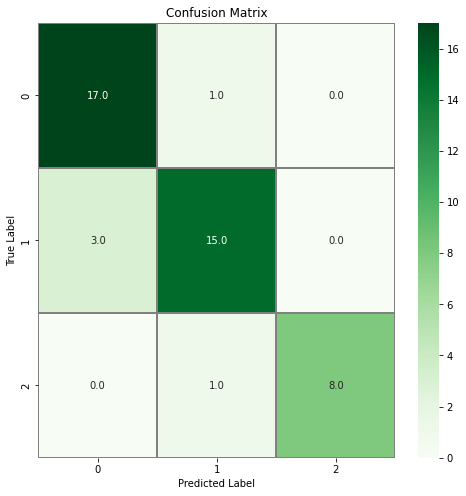

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.88      0.83      0.86        18
           2       1.00      0.89      0.94         9

    accuracy                           0.89        45
   macro avg       0.91      0.89      0.90        45
weighted avg       0.89      0.89      0.89        45

[[1.44309560e-08 1.00000000e+00 6.07951600e-09]
 [7.99156010e-01 1.96876377e-01 3.96756083e-03]
 [6.25236467e-08 3.37733326e-08 9.99999881e-01]
 [9.97987986e-01 1.88181200e-03 1.30203858e-04]
 [1.44050393e-17 1.41544561e-19 1.00000000e+00]
 [5.42522641e-04 6.72781587e-01 3.26675922e-01]
 [6.02559745e-01 3.79331648e-01 1.81086138e-02]
 [1.33430453e-15 9.57093973e-16 1.00000000e+00]
 [2.67011777e-11 1.00000000e+00 1.79323922e-13]
 [1.81200512e-08 9.99999523e-01 4.33935440e-07]
 [9.93622243e-01 5.22489208e-05 6.32548844e-03]
 [9.81445014e-01 1.71395633e-02 1.41539366e-03]
 [1.20863578e-13 3.

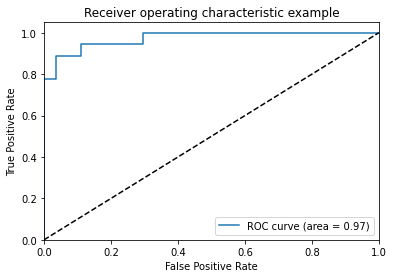

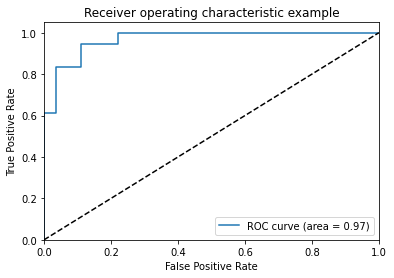

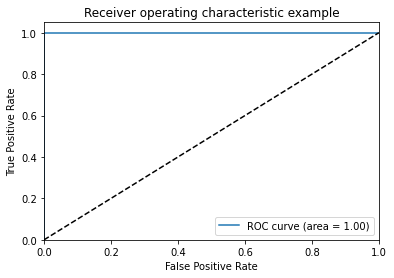

In [61]:
plot_accuracy_loss(history_VGG16_finetuning_RMS_bs4)
pred_labels, test_labels = make_predictions(VGG16_finetuning_RMS_bs4, test_X, test_Y)
print("Predictions: ", pred_labels)
print("Actual: ", test_labels)
plot_confusion_matrix(test_labels, pred_labels)
print_classification_report(test_labels, pred_labels)
plot_AUC_ROC(VGG16_finetuning_RMS_bs4, test_X, test_Y)

### **Testing VGG16 on PotsDam dataset**

10/10 [==============================] - 2s 233ms/step - loss: 0.8343 - acc: 0.7233
[2 0 2 2 2 0 2 2 1 2 2 2 2 1 2 1 0 0 2 0 2 2 2 0 2 1 2 1 2 1 0 2 0 0 0 0 1
 1 0 2 0 1 2 1 0 0 2 0 2 0 0 0 0 2 1 0 0 1 1 2 1 2 2 1 0 2 0 0 0 2 0 2 0 1
 2 1 1 1 2 0 2 1 2 1 0 2 2 0 1 1 1 1 0 0 1 2 0 2 2 2 0 2 2 2 0 2 0 0 1 2 1
 2 2 2 2 0 0 0 2 0 2 2 2 2 0 2 1 2 0 0 2 2 2 2 2 2 0 0 1 0 2 0 2 2 1 0 0 0
 2 0 2 0 2 2 0 2 2 0 2 1 2 0 1 0 1 2 2 2 2 0 0 0 2 1 2 0 2 0 2 0 0 0 0 2 2
 2 0 1 2 2 0 2 2 2 0 1 2 2 0 1 0 2 2 2 1 0 1 2 2 0 0 1 2 2 2 1 1 1 1 2 2 2
 0 0 2 0 2 0 2 0 2 0 1 2 2 2 1 2 1 0 1 1 0 2 2 2 2 1 1 1 2 0 1 0 2 0 0 1 2
 0 2 2 0 0 2 0 2 2 2 2 1 0 0 0 2 1 2 1 0 2 2 2 0 2 2 1 2 1 0 0 0 1 1 1 0 0
 0 2 2 0]
[1 0 2 2 1 0 2 2 0 2 2 2 2 1 2 0 0 0 2 0 1 1 0 1 2 1 2 1 2 0 1 2 0 0 0 0 1
 0 0 2 0 0 1 0 1 0 1 0 2 0 0 0 1 2 1 1 0 1 0 2 0 2 2 1 0 1 0 0 0 0 0 2 0 1
 2 1 1 1 2 0 2 1 1 1 1 2 2 0 1 1 1 1 0 1 0 2 1 2 2 2 1 2 1 2 0 2 0 0 1 2 1
 2 2 2 1 0 0 0 2 0 1 2 1 2 1 2 1 1 1 0 2 1 2 1 1 2 0 0 1 0 2 0 2 1 0 1 0 1
 2 0 2

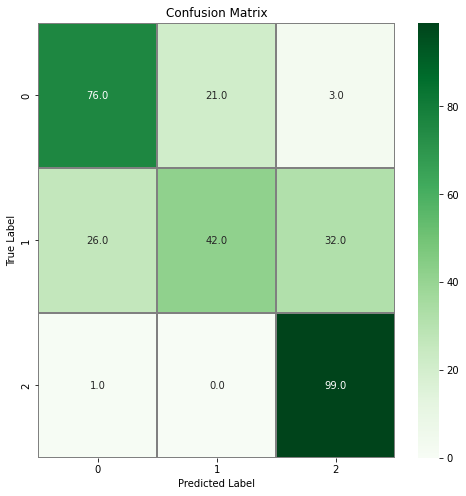

In [62]:
VGG16_finetuning_RMS_bs4 = tf.keras.models.load_model('./VGG16-50epochs-RMS-bs4-mod2')
test_loss = VGG16_finetuning_RMS_bs4.evaluate(train_X_potsdam, train_Y_potsdam)
predictions = VGG16_finetuning_RMS_bs4.predict(train_X_potsdam)
pred_labels = np.argmax(predictions, axis = 1)
test_labels = np.argmax(train_Y_potsdam, axis = 1)
print(pred_labels)
print(test_labels)
print(test_loss)
print_classification_report(test_labels, pred_labels)
plot_confusion_matrix(test_labels, pred_labels)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[1, 0, 2, 2, 1, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 1, 0, 0, 0, 0, 2, 0, 2, 0, 1, 2, 1, 0, 0, 1, 1, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 2, 2, 1, 2, 1, 1, 1, 2, 0, 2, 1, 2, 1, 0, 2, 2, 0, 1, 1, 1, 1, 1, 0, 1, 2, 0, 2, 2, 2, 0, 2, 1, 2, 0, 2, 1, 0, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 1, 2, 0, 0, 1, 0, 2, 0, 2, 1, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 0, 2, 1, 2, 1, 0, 0, 1, 2, 2, 2, 1, 0, 2, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1, 0, 2, 2, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 1, 2, 1, 2, 2, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 2, 1, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 0, 0, 0, 1, 1, 1, 0, 0, 1, 2, 2, 0]


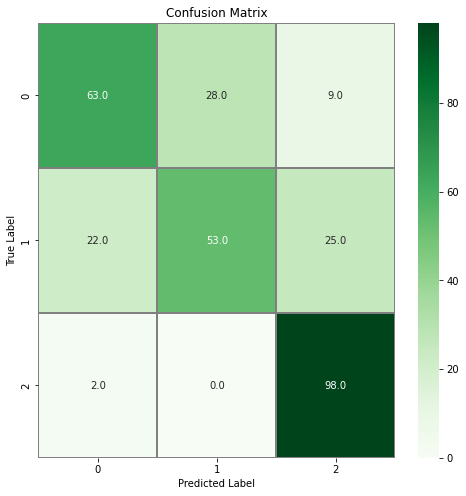

Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       100
           1       0.65      0.53      0.59       100
           2       0.74      0.98      0.84       100

    accuracy                           0.71       300
   macro avg       0.71      0.71      0.70       300
weighted avg       0.71      0.71      0.70       300

0.7133333333333334


In [63]:
acc, yhats = tta_evaluate_model(VGG16_finetuning_RMS_bs4, train_X_potsdam, train_Y_potsdam)
print(acc)